In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines
import numpy as np
from numpy import pi
from numpy import sqrt
from IPython.display import Image
from qutip import *
from qutip.measurement import *
import math
import random

# Beamsplitters and the quantum HOM effect
Main reference: C. K. Hong, Z. Y. Ou, and L. Mandel, "Measurement of subpicosecond time intervals between two photons by interference", Phys. Rev. Lett. 59, 2044 – Published 2 November 1987

In this notebook we use a very simple optical component: A beamsplitter. We will start by looking at a beamsplitter which leaves half of the light through and which reflects the other half, and later we will vary the reflectance and transmittance. For single photons we find the expected, and rather boring outcome that the photon either passes through the beamsplitter, or is reflected by the beamsplitter with a probability depending on the reflectance or transmittance of the beamsplitter. For a 50%/50% beamsplitter you would find an input photon with equal likelihood in any of the output ports of the beamsplitter.

However, when using two photons it gets a lot more interesting. We see that when the photons are fundamentally 'indistinguishable' an effect occurs leading to the two photons always being together in any of the outputs. This 'bunching' is known at the HOM effect, named after Hong, Ou and Mandel (see their paper "Measurement of subpicosecond time intervals between two photons by interference" which is the main reference for this notebook)

In this notebook we first describe a beamsplitter with the input and output states in such a way that we can easily model it in Python Qutip. We then define some Python functions as a kind of 'infrastructure' to simulate the effect of the beamsplitter. Then we use this model first for single photons, and then for photon pairs. To dive deeper we use a varying polarization to continuously vary the level of 'indistinguishability', and also play with the reflectance and transmittance of the beamsplitter. As final chapter we explain the results through quantum interference as well as the statistics of bosons (where a boson is the class or quantum particles to which photons belong.)

- [Introduction: The beamsplitter](#The_beamsplitter)
- [Modelling Fock states](#Fockstates)
- [Infrastructure](#Infrastructure)
- [Setting up the optical system](#Optical_system)
- [Measuring statistics with single photons](#Single_photons)
- [Measuring statistics with photon pairs](#Photon_pairs)
- [Varying the degree of 'indistinguishability'](#Indistinguishability)
- [Explaining the effect by 'quantum interference' and the 'boson-bonus'](#Interference)

<a id="The_beamsplitter"></a>
## Introduction: The beamsplitter
We use a simple Qutip model to mimic the actual experiments. In this model we use a 4 channel Fock state for the input and the output. At the input the 4 channels represent the horizontal and vertical polarization at input port 1 and input port 2. So for example $|1000>$ would represent 1 horizontally polarized photon at input port 1, while $|0001>$ would represent a vertically polarized photon at input port 2. $|1010>$ would represent a horizontally polarized photon at port 1 and port 2 simultaneously, while $|0011>$ would represent a horizontally and a vertically polarized photon both at port 2. For the output the logic is similar: $|1000>$ reprents a photon with horizontal polarization at output port 1, while $|0020>$ represents a state with two horizontally polarized photons at output port 2. In this notebook we limit ourselves to 4 channels, and maximum 2 photons in the system.

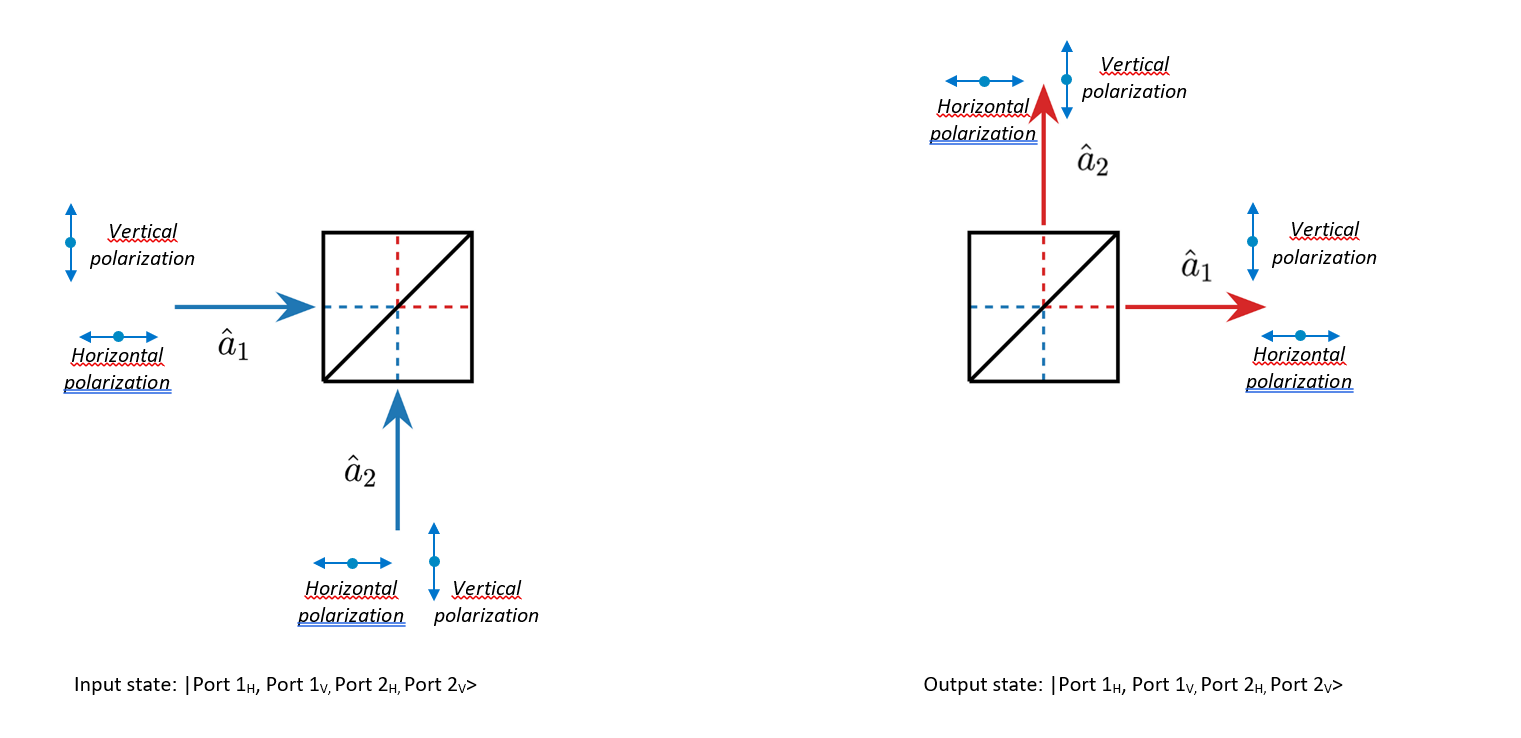

In [3]:
Image(filename='./Polarizer_with_input_and_output.png')

We limit ourselves to the case where the beamsplitter is not polarization dependent, i.e., the situation where the beamsplitter works the same for any polarization at the input ports. We will however vary the polarization of the light between the two different input ports and between the light at the input port and the detectors behind the output port. So, the beamsplitter itself is not polarization dependent, but we will vary the polarization of the input light and the polarization direction of the output detection.

This system can be modelled by a sequence of 'mixing' two of the channels in the 4-channel Fock state. For the beamsplitter we can first 'mix' channel 0 and channel 2, and after that channel 1 and channel 3. For changing the polarization at the input or output we 'mix' channels 0 and 1, or channels 2 and 3. If we limit ourselves to either horizontal/vertical polarization or diagonal polarization, and if we also limit ourselves to a 50/50 beamsplitter the 'mixing' is always describe by the same matrix. Note that the channels are Fock states and can contain any number of photos (0,1,2, ...), so we are not using qubits whose value can only be 0 or 1.

<a id="Fockstates"></a>
## Working with Fock states

Above we already stated that we use a 4 channel Fock state, meaning we have 4 'channels' and each channel can contain 0,1,2,3, .. photons. Let's have a closer look at the possible states for this system.

### Single photons
If we have only one photon we can have the situation that this photon is uniquely in one single channel. For instance, for state $|0001>$ we have a 100% probability of finding a photon in channel 3, so to detect the outcome '0001'. There is no ambiguity, we always get the same outcome and know exactly in which channel to find the photon.

Alternatively we can have the situation that we sometimes measure the photon in channel 1 (so detect the outcome '0100') and sometimes in channel 3 (so detect the outcome '0001'). In that case the state would be $\alpha \cdot |0001> + \beta \cdot |0100>$. We then have probability $|\alpha|^{2}$ of detecting the photon in channel 3 (so detect '0001') and $|\beta|^{2}$ of detecting the photon in channel 1 (so detect '0100'). Here $|\alpha|^{2} + |\beta|^{2} = 1$, as we need to have a 100% change of detecting the photon somewhere.

In this example we call $|0001>$ and $|0100>$ the __components__ of the state. $\alpha$ and $\beta$ are the __amplitudes__. Each component has a unique __outcome__ for the measurement (like in this case '0001' or '0100'. The __probability__ to find a certain measurement outcome ('0001' or '0100') is the square of the absolute value of the amplitude (so $|\alpha|^{2}$ or $|\beta|^{2}$ )

### Two photons
For two photons in a state we have similar logic. Also here the state is build from __components__, with __amplitudes__ and __probabilities__ to detect a certain measurement __outcome__. Of course in this case we could detect two photons in a single channel.

For $|0101>$ we have a 100% probability of finding exactly one photon in channel 3 and exactly one photon in channel 1. So we will always detect the outcome '0101'

For $|0200>$ we have a 100% probability of finding two photons in channel 1  So we will always detect the outcome '0200'

In the above cases the states consist of only one component, which then has amplitude 1 and detection probability of 100%. For $\alpha \cdot |0101> + \beta \cdot |1010>$ we have probability $|\alpha|^{2}$ of detecting the photons in channels 1 and 3 (so detect '0101') and $|\beta|^{2}$ of detecting the photon2 in channels 0 and 2 (so detect '1010'). Here $|\alpha|^{2} + |\beta|^{2} = 1$, as we need to have a 100% change of detecting two photons.

For $\alpha \cdot |1001> + \beta \cdot |1010>$ we have probability $|\alpha|^{2}$ of detecting the photons in channels 0 and 3 (so detect '1001') and $|\beta|^{2}$ of detecting the photon 2 in channels 0 and 2 (so detect '1010'). Here $|\alpha|^{2} + |\beta|^{2} = 1$, as we need to have a 100% change of detecting two photons. This means we always detect __one__ photon in channel 0, and only see variation in the dection of the photon in channel 2 or 3. Note that although we have two components which have a photon in channel 0 we never detect 2 photons in this channel, $|2000>$ is not a component so outcome '2000' will not be detected. 

### Combining single photon states into one single two-photon state
Now we can try to 'build' two photon states from single photon states. Intuitively, we could predict from the single photon outcomes the probability for the two photon outomes. For instance, if we would have one photon in $|0001>$ and another photon in $|0100>$ the combined state woul be $|0101>$ and we detect with 100% certainty the outcome '0101'.

Imagine now that we combine two photons with the states: $\alpha_{1} \cdot |0100> + \beta_{1} \cdot |0001>$, and $\alpha_{2} \cdot |1000> + \beta_{2} \cdot |0010>$. We then need $|\alpha_{1}|^{2} + |\beta_{1}|^{2} = 1$ and $|\alpha_{2}|^{2} + |\beta_{2}|^{2} = 1$. The final state is then  $\alpha_{1}\alpha_{2} \cdot |1100> + \beta_{1}\alpha_{2} \cdot |1001> + \alpha_{1}\beta_{2} \cdot |0110> + \beta_{1}\beta_{2} \cdot |0011>$. In this example the likelihood of detecting one photon in channel 0 and one photon in channel 1 (outcome '1100') would be $|\alpha_{1}\alpha_{2}|^{2}$. It is easy to proof that $|\alpha_{1}\alpha_{2}|^{2} + |\beta_{1}\alpha_{2}|^{2} + |\alpha_{1}\beta_{2}|^{2} + |\beta_{1}\beta_{2}|^{2} = 1$, so we are sure to detect any of the possible outcomes and will always find the two photons back in the measurement result.

The above result can be derived intuitively. The likelihood for detecting outcome '1100' is  $|\alpha_{1}\alpha_{2}|^{2}$, which is $|\alpha_{1}|^{2} \cdot |\alpha_{2}|^{2}$. This the 'simply' multiplication of the probability of detecting the two photons in channel 0 and channel 1 for the single photon states. What is important is that for the combined state we multiply the amplitudes of the 'single photon' contributions to come to the amplitude of the 'two photon' outcome. The likelihood of detecting a specific 'two photon' outcome is then the square of this amplitude (or square of the absolute value of the amplitude if we take phases into account, for this notebook we can ignore this).

Now there are two important factors to consider in quantum theory, and these aspects break the 'intuitiveness' of the result.

> Quantum interference

One aspect is that in the final state there can be an 'outcome' which shows up multiple times with different amplitudes. There could for instance be a situation where either two photons are reflected by a beamsplitter, or two photons are transmitted by a beamsplitter both leading to the same detection outcome. In that case we have to add up the amplitudes for this outcome, before we take the square to calculate probability. If one of the amplitudes is positive, and the other is negative we have to in fact substract the amplitudes and the probability of finding this outcome will be reduced. Imagine we have the component $\alpha \cdot |0101>$ and the component $-\beta \cdot |0101>$. In the resulting state we then have $(\alpha - \beta) \cdot |0101>$, with probability $|\alpha - \beta|^{2}$. Note that this effect only takes place if the photons come together in the same state. If we would first detect one photon in state with component $\alpha \cdot |0100>$ the probability of measuring outcome '0100' would be $|\alpha|^2$, for the second photon (arriving later) the probability of detecting $|0001>$ would be $|\beta|^{2}$ (the minus sign disappears in the absolute value). There is no quantum interference in this case.

> Boson bonus

One other aspect is that for photons (as for other bosons) there is a preference of grouping together in the same state. This means that if we combine two single states and the resulting state has a component where both photons are in the same channel (like $|0200>$), this component gets an additional factor of $\sqrt{2}$ in the amplitude. As example let us combine $\alpha_{1} \cdot |0100> + \beta_{1} \cdot |0001>$, and $\alpha_{2} \cdot |0100> + \beta_{2} \cdot |0001>$. The resulting state will have a component $\alpha_{1}\alpha_{2}\sqrt{2}\cdot  |0200>$, where the $\sqrt{2}$ is purely coming from the fact that there is a channel with photon number 2, i.e., a channel which is occupied by two photons. Would we have a situation where we combine three states we could end up with $\alpha_{1}\alpha_{2}\alpha_{3}\sqrt{3}\cdot  |0300>$, so the 'bonus factor' scales as the square root of the photon occupancy in the final state. Note that this effect only takes place if the two photons come together in the same state and are also detected in this state. If the photons arrive sequentially they would not group together, and the 'boson-bonus' would not be applicable

The two effects above lead to the situation that the probably of detecting a certain outcome deviates from what one would expect by looking at the two photons individually. The 'quantum interference' can only happen if the photons arrive simultaneously, and also the 'boson-bonus' is only applicable for two photons detected at the same time. Obviously in any case the probabilities of the different components have to add up to exactly 100% in order to ensure that we detect all photons that we put into the system also at the output (we ignore any photon absorption or creation). What we will see is that the 'quantum interference' and 'boson-bonus' work together to ensure this.

### Beamsplitters and mixing matrices
Above we discussed how our optical system can be described by a Fock state indicating the number of photons per channel. Modifying this state happens through optical components like beamsplitters, which we mathematically describe by matrices. These matrices act on the __amplitude__ of the components of the state. 

> Two channels

To model the beamsplitter we define the matrix below for mixing two channels. Here the transmission coefficient is $t$ and the reflection coefficient is $r$. These coefficients act on the ampitudes. So if for instance $t = r = \frac{1}{\sqrt{2}}$ the probability to be reflected is $r^{2} = \frac{1}{2}$ and the probability to be transmitted is $t^{2} = \frac{1}{2}$. So this would be a 50%/50% beamsplitter equally splitting the light between the output ports. Below we see a picture representing this beamsplitter as mixing two channels, where it is important to not the 'minus sign' that has to be included for transmission from input port 2 to output port 2.

 $\begin{pmatrix}
  r & t \\
  t & -r \\
 \end{pmatrix}$

So for input state $|10>$ the output state is $|rt>$, and for $|01>$ the output state is $-|tr>$

There are some special cases which we will use further down in this notebook
> We can make a 'swap' matrix to simply swap the two channels. $|10> \rightarrow |01>$ and $|01> \rightarrow |10>$. In this case we set $r$ equal to zero and $t$ equal to 1.

 $\begin{pmatrix}
  0 & 1 \\
  1 & 0 \\
 \end{pmatrix}$

> The 50%/50% beamsplitter we use mostly in this notebook is modelled by using $\frac{1}{\sqrt{2}} = \frac{1}{2} \sqrt{2}$ for both the reflection ($r$) and transmission ($t$) coefficient. The matrix then looks like 
 
 $\begin{pmatrix} \frac{1}{2} \sqrt{2} & \frac{1}{2} \sqrt{2} \\ \frac{1}{2} \sqrt{2} & -\frac{1}{2} \sqrt{2} \\ \end{pmatrix} =  
 \frac{1}{2} \sqrt{2} \begin{pmatrix} 1 & 1 \\ 1 & -1 \\ \end{pmatrix}$
 
> We can also make a beamsplitter with a different ratio between transmission and reflection, as long as $|r|^{2} + |t|^{2}  = 1$ (we still assume the beamsplitter to be lossless, all light that enters comes out somewhere). To use this generic beamsplitter we take the matrix below where $r$ equals $\cos(\theta)$ and $t$ equals $\sin(\theta)$

 $\begin{pmatrix}
  \cos(\theta) & \sin(\theta) \\
  \sin(\theta) & -\cos(\theta) \\
 \end{pmatrix}$

 For more information on how to descrive a beamsplitter with a matrix check out https://en.wikipedia.org/wiki/Beam_splitter or https://www.pas.rochester.edu/~howell/mysite2/Tutorials/Beamsplitter2.pdf. Note that there are different 'conventions' where you can also find the matrix for a 50/50 beamsplitter as  
 
 $\frac{1}{2} \sqrt{2} \begin{pmatrix} 1 & i \\ i & 1 \\ \end{pmatrix}$

 or as 

  $\frac{1}{2} \sqrt{2} \begin{pmatrix} 1 & -1 \\ 1 & 1 \\ \end{pmatrix}$

All these approaches are equally correct, if used consistently. 

Below we first show some computer experiments, and then come back to the effect of 'quantum interference' and the 'boson-bonus' to explain in detail what we observe.

>  4 channels

To generalize the two channel matrices for a 4 channel system we can simply extend the matrix. For instance, for only mixing channels 0 and 1 in a 4 channel system the matrix would be like:

 $\begin{pmatrix}
  r & t & 0 & 0 \\
  t & -r & 0 & 0\\
  0 & 0 & 1 & 0 \\
  0 & 0 & 0 & 1
 \end{pmatrix}$

 Mixing channels 1 and 3 would look like:

 $\begin{pmatrix}
  1 & 0 & 0 & 0 \\
  0 & r & 0 & t\\
  0 & 0 & 1 & 0 \\
  0 & t & 0 & -r
 \end{pmatrix}$

 


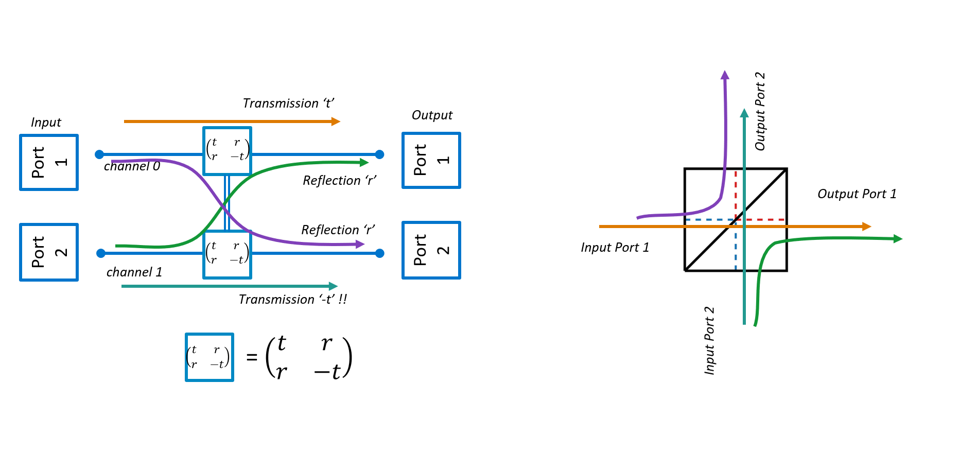

In [ ]:
Image(filename='./Setup_two_channel_beamsplitter.png')

As general settings we have to define the 'number of channels' as well as the maximum amount of photons per channel. For number of channels we choose 4, as we have two ports at input and output, with each two polarization directions. We look at maximum two photons, so for any single channel the maximum count of photons would be 2. As any channel is therefore in a state with zero, one or two photons the variable 'length_of_fock_state' is set to 3.

In [ ]:
length_of_fock_state = 3 # max number of photons in a channel is 2, so possible states are |0>, |1> or |2>
no_of_channels = 4 # the beamsplitter has two input and two output channels, so we work with two channels that are''mixed' by the beamsplitter

<a id="Infrastructure"></a>
## Infrastructure

### Modelling the beamsplitter and the polarization rotation
To model the beamsplitter we define teh function `mixing_matrix(r,t)` for mixing two channels. Here the transmission coefficient is `t` and the reflection coefficient is `r`. 

 $\begin{pmatrix}
  r & t \\
  t & -r \\
 \end{pmatrix}$

 To use this generic beamsplitter we call the function with `mixing_matrix(math.cos(theta),math.sin(theta))`, `r` equals $\cos(\theta)$ and `t` equals $\sin(\theta)$

 $\begin{pmatrix}
  \cos(\theta) & \sin(\theta) \\
  \sin(\theta) & -\cos(\theta) \\
 \end{pmatrix}$

In [ ]:
def mixing_matrix(r,t):
    # Tihs function creates a matrix to mix two channels, where each channel can be in a Fock state of maximum 'length_of_fock_state - 1' photons.
    data = np.zeros((length_of_fock_state**2,length_of_fock_state**2)) # Data for Qobj operator to model the mixing
    for l1 in range(0,length_of_fock_state**2):
        n = int(l1%length_of_fock_state)
        m = int((l1-n)/length_of_fock_state)
        #n and m are input photon numbers, l1 is the counter for output data. l1 = m * length_of_fock_state + n
        #the input is a state |n>|m> . The mixing has a transmission (t) and a reflection (r)
        #the matrix is [t,r],[r,-t]. Output is a sum of states |u>|v>
        #so transformation is  |n>|m>|0>|0>  to (a**n)(b**m)|0>|0>|0>|0> to  Sum((c**u)(d**v)|0>|0>|0>|0>) to Sum(|0>|0>|u>|v>)
        #(tu + rv)**n (ru - tv)**m = 
        for i in range(0,n+1):
            for j in range(0,m+1):
                u = (n+m) - (i+j)
                v = (i+j)
                #the factor from the binomial expansion
                coeff = math.comb(n,i)*math.comb(m,j)*(r**(n-i))*(t**(m-j))*(t**(i))*((-r)**(j))
                #factor in sqrt n for boson raising operation c|n> = sqrt(n+1)|n+1> and l|n> = sqrt(n)|n-1>. <n|a*a|n> = n
                coeff = coeff * sqrt(math.factorial(u)*math.factorial(v)/(math.factorial(n)*math.factorial(m)))
                #total number of photons cannot exceed (length-1) for each of the output channels
                if ((u < length_of_fock_state) and (v < length_of_fock_state)):
                    l2 = v * length_of_fock_state + u
                    data[l1,l2] = data[l1,l2] + coeff
    return Qobj(data,[[length_of_fock_state, length_of_fock_state], [length_of_fock_state, length_of_fock_state]], shape = (length_of_fock_state**2, length_of_fock_state**2))
    #Note, this is for two channels, needs extension for full basis via a tensor product

### Defining the input mode
As we have a system with 4 'channels' the vacuum mode (the situation with no light in either of the channels) is $|0000>$. We define the functions `raise_state(n)` and `lower_state(n)` to modify the state. As example `raise_state(n)` raises the photon number in the n-th state by one:

$\begin{array}{lcl}
|1000> & = & \text{raise\_state(0) *} |0000> \\
|0010> & = & \text{raise\_state(2) *} |0000> \\
|1010> & = & \text{raise\_state(0) *} |0010> \\
|1010> & = & \text{raise\_state(0) * raise\_state(2) *} |0000>
|2000> & = & \text{raise\_state(0) *} |1000> \\
|2000> & = & \text{raise\_state(0) * raise\_state(0) *} |0000>
\end{array}$

The function `lower_state(n)` works in a similar way:

$\begin{array}{lcl}
|0000> & = & \text{lower\_state(0) *} |1000> \\
|0000> & = & \text{lower\_state(2) *} |0010> \\
|0001> & = & \text{lower\_state(3) *} |0002> \\
|1001> & = & \text{lower\_state(1) * lower\_state(2) *} |1111>
|0001> & = & \text{lower\_state(1) * lower\_state(1) *} |0201>
\end{array}$

Note that this definition is not the same as for the boson creation and annihilation operators. We did not include the scaling factor or 'boson bonus' which normally would be applied. This factor has to be added separately.

$\begin{array}{lcl}
a^{\dagger} |n> & = &  \sqrt{n+1}|n+1> \\
a |n> & = &  \sqrt{n}|n-1> 
\end{array}$

The $\sqrt{n+1}$ and $\sqrt{n}$ are not included in `raise_state(n)` and `lower_state(n)`.


In [ ]:
def raise_state(n):
    # function to raise the Fock state of channel n by 1. So state |k>  will be state |k+1>.
    I = identity(length_of_fock_state)
    swap_list = [k for k in range(no_of_channels)]
    swap_list[0], swap_list[n] = swap_list[n], swap_list[0]
    data = np.zeros((length_of_fock_state,length_of_fock_state))
    for i in range(0,length_of_fock_state-1):
        data[i+1,i] = 1
    raise_operator = Qobj(data,[[length_of_fock_state], [length_of_fock_state]], shape = (length_of_fock_state, length_of_fock_state))
    for j in range(1, no_of_channels):
            raise_operator = tensor(raise_operator, I)
    raise_operator = raise_operator.permute(swap_list)
    return raise_operator

def lower_state(n):
    # function to reduce the Fock state of channel n by 1. So state |k>  will be state |k-1>.
    I = identity(length_of_fock_state)
    swap_list = [k for k in range(no_of_channels)]
    swap_list[0], swap_list[n] = swap_list[n], swap_list[0]
    data = np.zeros((length_of_fock_state,length_of_fock_state))
    for i in range(0,length_of_fock_state-1):
        data[i,i+1] = 1
    lower_operator = Qobj(data,[[length_of_fock_state], [length_of_fock_state]], shape = (length_of_fock_state, length_of_fock_state))
    for j in range(1, no_of_channels):
            lower_operator = tensor(lower_operator, I)  
    lower_operator = lower_operator.permute(swap_list)
    return lower_operator

### Performing a measurement
This function performs the actual measurement, repeated `no_of_measurements` times. The result is returned in a Python dictionary. This dictionary has a keys the measurement result, and as value the number of times this outcome occured. If the outcome did not occur the key is not in the dictionary. The key is formatted as a string with for each channel a digit. So result `{'1000' : 10, '0010':5}` means that the outcome where detecor in channel `0` detected a photon and the rest detected nothing occured 10 times, while the outcome where detecor in channel `2` detected a photon and the rest nothing occured 5 times. No other outcome was detected.

In [ ]:
def measure_the_state(in_state, no_of_measurements):
    # This function will return the result of N measurements on state 'in_state'. 
    # The result is stored in a dictonary with the measurement result as key and the occurence as the value
    # Example result  {'1001':2, '0110': 3}. Outcomes with occurence zero are not included in the dictionary
    I = identity(length_of_fock_state)
    # Z is the measurement projection for the single channels
    Z = []
    for i in range(0,length_of_fock_state):
        Z.append(ket2dm(basis(length_of_fock_state,i))) # |i><i| for i from 0 to "length_of_fock_state - 1"

    # X is the measurement projection for the first channel
    X = []
    for i in range(0,length_of_fock_state):
        for j in range(1, no_of_channels):
            Z[i] = tensor(Z[i], I)
        X.append(Z[i])
    
    # Y is the list of projectors for the various channels
    Y = []
    for j in range(0, no_of_channels):
        swap_list = [k for k in range(no_of_channels)]
        swap_list[0], swap_list[j] = swap_list[j], swap_list[0]
        for i in range(0, length_of_fock_state):
            Y.append([])
            Y[j].append(X[i].permute(swap_list))

    result = dict([]) # result is the dict which will contain all measurement outcomes and number of times they occur
    for _ in range(0,no_of_measurements):
        out_state = in_state
        value = []
        for j in range(0, no_of_channels):
            res, out_state = measure(out_state, Y[j]) # res is the outcome of the measurement, out_state is the wavefunction after the measurement
            value.append(res)
        val =''.join([str(v) for v in value]) # val is a string with the measurement result over the different channels
        if val in result:
            result[val] += 1
        else:
            result[val] = 1
    return result


### Performing measurements on photon pairs
As we in this notebook specifically study pairs of photons which either are distinguishable or not-distinguishable we make two functions to help. The function leverages the more general `measure_the_state(in_state, no_of_measurements)`. The function `photon_pairs_sequentially(channels, matrix, no_of_measurements)` executes two separate measurements with one photon and then groups the result together (so outcomes `1000` and `0010` would become `1010`and measuring `1000` for both photons would become `2000`). The function `photon_pairs_simultaneously(channels, matrix, no_of_measurements)` uses a state with two photons as input and detects them simultaneously.

In [ ]:
def photon_pairs_sequentially(channels, matrix, no_of_measurements):
    # Function to measure a photon pair sequentially (i.e., one after the other). 
    # This mimics the situation where both photons are fully distinguishable (they could be identified by their arrival time)
    result = dict([]) 
    vac = basis(length_of_fock_state,0)
    I = identity(length_of_fock_state)
    vacuum_state = vac
    for _ in range(1,no_of_channels):
        vacuum_state = tensor(vacuum_state, vac)
    for _ in range(no_of_measurements):
        ind = []
        for channel in channels:
            in_state = raise_state(channel) * vacuum_state
            out_state = matrix * in_state
            res = measure_the_state(out_state, 1)
            list_of_keys = list(res.keys())
            ind.append(list_of_keys[0])
        val = ''
        for i in range(len(ind[0])):
            if ind[0][i] == '1' and ind[1][i] == '1':
                val += '2'
            elif ind[0][i] == '0' and ind[1][i] == '0':
                val += '0'
            else:
                val += '1'
        if val in result:
            result[val] += 1
        else:
            result[val] = 1
    return result

def photon_pairs_simultaneously(channels, matrix, no_of_measurements):
    # Function to measure a photon pair simultaneously (i.e., both at the same time). 
    # This mimics the situation where both photons COULD BE indistinguishable, depending on other aspects like polarization or spatial mode.
    result = dict([]) 
    vac = basis(length_of_fock_state,0)
    I = identity(length_of_fock_state)
    vacuum_state = vac
    for _ in range(1,no_of_channels):
        vacuum_state = tensor(vacuum_state, vac)
    for _ in range(no_of_measurements):
        ind = []
        in_state = vacuum_state
        for channel in channels:
            in_state = raise_state(channel) * in_state
        out_state = matrix * in_state
    return measure_the_state(out_state, no_of_measurements)

<a id="Optical_system"></a>
# Setting up the optical system


In [ ]:
vac = basis(length_of_fock_state,0)
I = identity(length_of_fock_state)
# Define the optical components
# The non-polarizing 50/50 beamsplitter
mix = tensor(mixing_matrix(1/sqrt(2),1/sqrt(2)), I, I) # Matrix for mixing first two channels
NPBS = tensor(I, I, I, I) # This is the identity matrix operating on channels [0, 1, 2, 3]
NPBS = mix.permute([0,2,1,3]) * NPBS
NPBS = mix.permute([2,0,3,1]) * NPBS

# Diagonal polarization at the first input/output port
diagonal_01 = mix.permute([1,0,2,3])

# Diagonal polarization at the first input/output port
diagonal_23 = mix.permute([2,3,1,0])


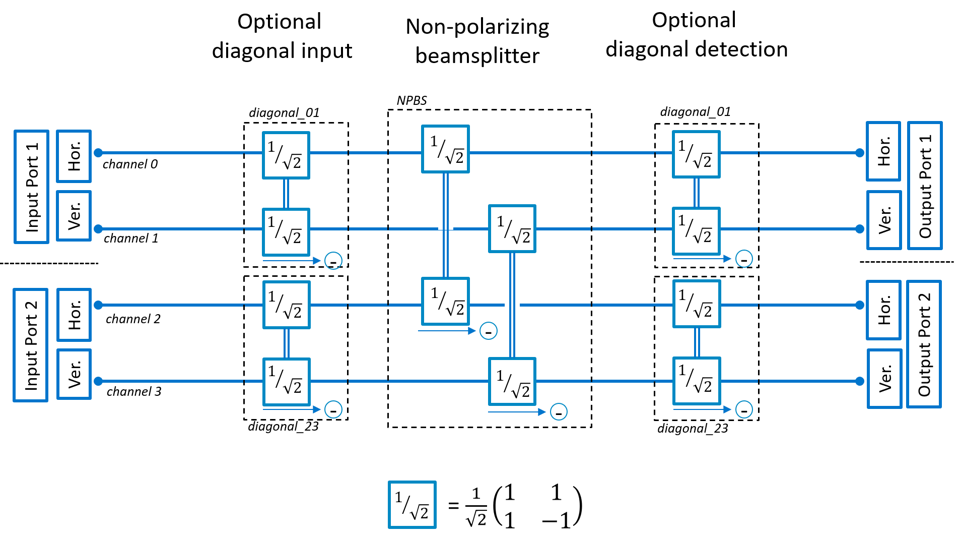

In [ ]:
Image(filename='./Setup_explanation.png')

<a id="Single_photons"></a>
## Measuring statistics with single photons

If we start with a horizontally polarizer photon at the first input port (input state $|1000>$) we find at the output 50% change of a horizontally polarized photon the first output (outcome '1000'), and  50% change on a horizontally polarized photon at the second output (outcome '0010'). If we start with a vertically polarized photon (input state $|0100>$) we find vertical polarization at the output, 50%/50% split between the ports (outcomes '0100' and '0001'). 

Starting with a diagonally polarized photon and leaving the detection in the horizontal/vertical polarization leads to finding a photon 50%/50% between the output ports, and also 50%/50% between horizontal and vertical polarization. So in this case all outcome ('1000', '0100', '0010' and '0001' are all equally likely).

If we change the detection also to the diagonal direction we again see that polarization is maintained in the beamsplitter. 

In [63]:
# define the vacuum state to hold maximum "length_of_fock_state - 1" photons (so for length_of_fock_state = 3 photon states can be |0>, |1>, |2> )

no_of_measurements = 100 # Number of repeats for each experiment

res = []
vacuum_state = tensor(vac, vac, vac, vac)
in_state = raise_state(0)* vacuum_state
out_state = NPBS * in_state
res.append(measure_the_state(out_state, no_of_measurements))
print("Horizontally polarized photon at the first input port", res[-1])

vacuum_state = tensor(vac, vac, vac, vac)
in_state = raise_state(1)* vacuum_state
out_state = NPBS * in_state
res.append(measure_the_state(out_state, no_of_measurements))
print("Vertically polarized photon at the first input port", res[-1])

vacuum_state = tensor(vac, vac, vac, vac)
in_state = diagonal_01 * raise_state(0)* vacuum_state
out_state = NPBS * in_state
res.append(measure_the_state(out_state, no_of_measurements))
print("Diagonally(+) polarized photon at the first input port ", res[-1])

vacuum_state = tensor(vac, vac, vac, vac)
in_state = diagonal_01 * raise_state(0)* vacuum_state
out_state = diagonal_01 * diagonal_23 * NPBS * in_state
res.append(measure_the_state(out_state, no_of_measurements))
print("Diagonally(+) polarized photon at the first input port, and also diagonally rotated polarization at the detectors behind the output ports", res[-1])

vacuum_state = tensor(vac, vac, vac, vac)
in_state = diagonal_01 * raise_state(1)* vacuum_state
out_state = diagonal_01 * diagonal_23 * NPBS * in_state
res.append(measure_the_state(out_state, no_of_measurements))
print("Diagonally(-) polarized photon at the first input port, and also diagonally rotated polarization at the detectors behind the output ports", res[-1])


Horizontally polarized photon at the first input port {'1000': 40, '0010': 60}
Vertically polarized photon at the first input port {'0001': 47, '0100': 53}
Diagonally(+) polarized photon at the first input port  {'0001': 32, '0100': 17, '1000': 25, '0010': 26}
Diagonally(+) polarized photon at the first input port, and also diagonally rotated polarization at the detectors behind the output ports {'0010': 51, '1000': 49}
Diagonally(-) polarized photon at the first input port, and also diagonally rotated polarization at the detectors behind the output ports {'0001': 47, '0100': 53}


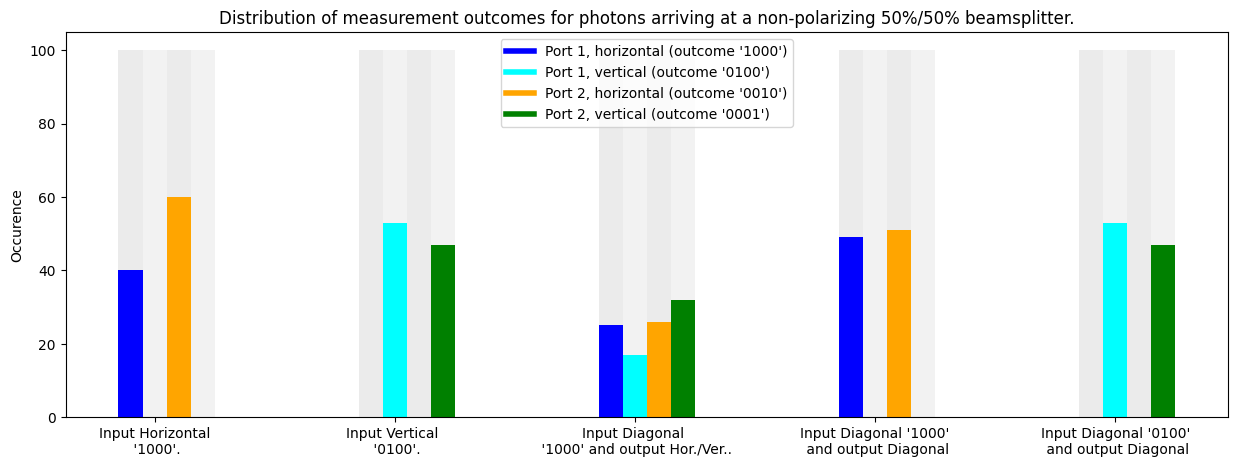

In [64]:
x = np.arange(5)
y = dict([])
categories = ['1000', '0100', '0010', '0001']
colors = ['blue', 'cyan', 'orange', 'green']
y = [[] for i in range(len(categories))]
for result in res:
    for i, category in enumerate(categories):
        if category in result.keys():
            y[i].append(result[category])
        else:
            y[i].append(0)

width = 0.1
plt.rcParams['figure.figsize'] = [15, 5]
# plot data in grouped manner of bar type
for i in range(len(y)):
    if i%2 == 0:
        plt.bar(x+width*(i - (len(y)-1)//2), no_of_measurements, width, color='silver', alpha = 0.3)
    else:
        plt.bar(x+width*(i - (len(y)-1)//2), no_of_measurements, width, color='grey', alpha = 0.1)
    plt.bar(x+width*(i - (len(y)-1)//2), y[i], width, color=colors[i])

plt.xticks(x, [
    'Input Horizontal\n \'1000\'.',
    'Input Vertical \n \'0100\'.',
    'Input Diagonal \n \'1000\' and output Hor./Ver..',
    'Input Diagonal \'1000\'\n and output Diagonal',
    'Input Diagonal \'0100\'\n and output Diagonal'
    ])
plt.ylabel("Occurence")
custom_lines = [matplotlib.lines.Line2D([0], [0], color='blue', lw=4),
                matplotlib.lines.Line2D([0], [0], color='cyan', lw=4),
                matplotlib.lines.Line2D([0], [0], color='orange', lw=4),
                matplotlib.lines.Line2D([0], [0], color='green', lw=4)]
plt.legend(custom_lines, ["Port 1, horizontal (outcome '1000')", "Port 1, vertical (outcome '0100')", "Port 2, horizontal (outcome '0010')", "Port 2, vertical (outcome '0001')"])
plt.title("Distribution of measurement outcomes for photons arriving at a non-polarizing 50%/50% beamsplitter.")
plt.show()

<a id="Photon_pairs"></a>
## Measuring statistics with photon pairs

Below we see the statistics in the measurement when using photon pairs, which either arrive sequentially or simultaneously. For the sequential photons we see the same statistics as for the single photons: We always see that polarization is maintained (i.e., 2 horizontally polarized photons at the input always gives two horizonally polarized photons at the output, one horizontally and one vertically polarized photon at the input gives the same at the output). Also, we see that we always have the same occurence of 'bunching' (i.e., two photons in one port) as the occurence of 'anti-bunching' (i.e., one photon in each output port).

If the photons arrive simultaneously and have a different polarization nothing changes, we still see the statistics observed for sequential photons with the same occurence of 'bunching' and 'anti-bunching'.

If however we have two photons with the same polarization entering the two ports simultaneously we see a special effect. The anti-bunchin disappears and the photons only show up together behind one of the output ports. This is the famous HOM-effect, named after Hong, Ou and Mandel.

If we rotate the polarization at the input by 45 degrees to diagonal orientation and also use diagonal polarization at the detectors we also see only 'bunching'. So clearly the HOM effect does not depend on polarization, as long as the polarization of the photons is the sames (and as long as they arrive simultaneously).

In [59]:
no_of_measurements = 100
res = []
# two photons with orthogonal polarization
res.append(photon_pairs_sequentially([0, 3], NPBS, no_of_measurements))
print("Sequential pairs, orthogonal", res[-1])
res.append(photon_pairs_simultaneously([0, 3], NPBS, no_of_measurements))
print("Simultaneous pair, orthogonal", res[-1])

# two photons with parallel polarization
res.append(photon_pairs_sequentially([0, 2], NPBS, no_of_measurements))
print("Sequential pairs, parallel", res[-1])
res.append(photon_pairs_simultaneously([0, 2], NPBS, no_of_measurements))
print("Simultaneous pair, parallel", res[-1])

# two photons with diagonal polarization
res.append(photon_pairs_sequentially([0, 2], NPBS * diagonal_01 * diagonal_23, no_of_measurements))
print("Sequential pairs, parallel and diagonal", res[-1])
res.append(photon_pairs_simultaneously([0, 2], NPBS * diagonal_01 * diagonal_23, no_of_measurements))
print("Simultaneous pair, parallel and diagonal", res[-1])

# two photons with diagonal polarization in the input and for detectors
res.append(photon_pairs_sequentially([0, 2], diagonal_01 * diagonal_23 * NPBS * diagonal_01 * diagonal_23, no_of_measurements))
text = "Sequential pairs, parallel and diagonal with also diagonal orientation of the detectors"
print(text, res[-1])
res.append(photon_pairs_simultaneously([0, 2], diagonal_01 * diagonal_23 * NPBS * diagonal_01 * diagonal_23, no_of_measurements))
text = "Simultaneous pair, parallel and diagonal with also diagonal orientation of the detectors"
print(text, res[-1])


Sequential pairs, orthogonal {'0011': 26, '1100': 30, '0110': 21, '1001': 23}
Simultaneous pair, orthogonal {'1001': 21, '1100': 30, '0110': 20, '0011': 29}
Sequential pairs, parallel {'2000': 28, '0020': 29, '1010': 43}
Simultaneous pair, parallel {'0020': 46, '2000': 54}
Sequential pairs, parallel and diagonal {'1001': 6, '0200': 10, '0020': 5, '0110': 15, '0101': 13, '0011': 7, '1010': 13, '0002': 6, '2000': 12, '1100': 13}
Simultaneous pair, parallel and diagonal {'0200': 8, '0011': 35, '2000': 11, '1100': 21, '0020': 15, '0002': 10}
Sequential pairs, parallel and diagonal with also diagonal orientation of the detectors {'0020': 26, '1010': 55, '2000': 19}
Simultaneous pair, parallel and diagonal with also diagonal orientation of the detectors {'2000': 58, '0020': 42}


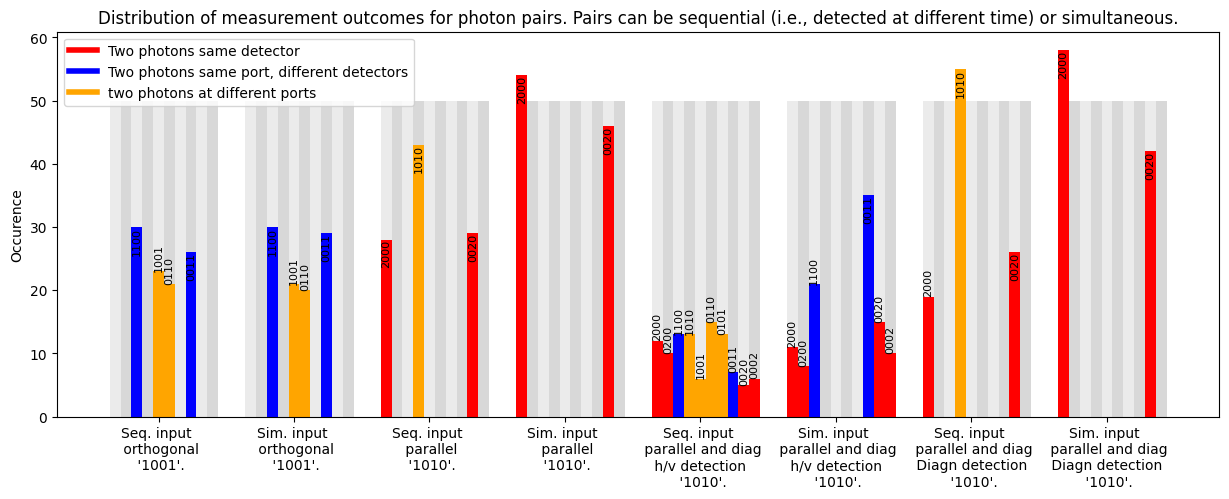

In [61]:

x = np.arange(8)
y = dict([])
categories = ['2000', '0200', '1100', '1010', '1001', '0110',  '0101', '0011', '0020', '0002']
colors = ['red', 'red',  'blue', 'orange', 'orange', 'orange', 'orange', 'blue', 'red', 'red']
y = [[] for i in range(len(categories))]
for result in res:
    for i, category in enumerate(categories):
        if category in result.keys():
            y[i].append(result[category])
        else:
            y[i].append(0)
width = 0.08
plt.rcParams['figure.figsize'] = [15, 5]
# plot data in grouped manner of bar type
for i in range(len(y)):
    if i%2 == 0:
        plt.bar(x+width*(i - (len(y)-1)//2), 50, width, color='silver', alpha = 0.3)
    else:
        plt.bar(x+width*(i - (len(y)-1)//2), 50, width, color='grey', alpha = 0.3)
    plt.bar(x+width*(i - (len(y)-1)//2), y[i], width, color=colors[i])

for xx in x:
    for i in range(len(y)):
        if y[i][xx] != 0 and y[i][xx] > 25:
            plt.text(xx+width*(i - (len(y)-1)//2), y[i][xx],categories[i], rotation=90, horizontalalignment='center', verticalalignment='top', fontsize=8)
        if y[i][xx] != 0 and y[i][xx] <=25:
            plt.text(xx+width*(i - (len(y)-1)//2), y[i][xx],categories[i], rotation=90, horizontalalignment='center', verticalalignment='bottom', fontsize=8)
    

plt.xticks(x, [
    'Seq. input \n orthogonal\n \'1001\'.',
    'Sim. input \n orthogonal\n \'1001\'.',
    'Seq. input \n parallel\n \'1010\'.',
    'Sim. input \n parallel\n \'1010\'.',
    'Seq. input \n parallel and diag\n h/v detection \n \'1010\'.',
    'Sim. input \n parallel and diag\n h/v detection \n \'1010\'.',
    'Seq. input \n parallel and diag\n Diagn detection \n \'1010\'.',
    'Sim. input \n parallel and diag\n Diagn detection \n \'1010\'.',
    ])
plt.ylabel("Occurence")
custom_lines = [matplotlib.lines.Line2D([0], [0], color='red', lw=4),
                matplotlib.lines.Line2D([0], [0], color='blue', lw=4),
                matplotlib.lines.Line2D([0], [0], color='orange', lw=4)]
plt.legend(custom_lines, ['Two photons same detector', 'Two photons same port, different detectors', 'two photons at different ports'])
plt.title("Distribution of measurement outcomes for photon pairs. Pairs can be sequential (i.e., detected at different time) or simultaneous.")
plt.show()

<a id="Indistinguishability"></a>
## Varying the degree of 'indistinguishability'

### Changing the polarization of the input ports to vary 'indistinguishability'

In literature it is mentioned that the HOM effect is driven by photon 'indistinguishability'. In the detection statistics we observe in the computer experiments we indeed see that for photons arriving simultaneously (i.e., we cannot identify by their arrival time) we see the HOM effect, while if the photons arrive sequentially (i.e., they come one at a time and could be identified by their arrival time) teh effect disappears. The effect also disappears is both photons have different polarization (so if we could identify they by their polarization).

Let's now look what happens if we rotate the polarization at of the input ports from orthogonal to parallel. In that case we gradually vary the photons from being fully disinguishable to fully indistinguishable.

In [25]:
bunched = ['2000','0200', '0020', '0002', '1100', '0011']
antibunched = ['1001','0110', '1010', '0101']
curve = dict([])
no_of_steps_for_rotation = 40
no_of_measurements = 250
for i in range(no_of_steps_for_rotation+1):
    theta = 2*i*math.pi/(no_of_steps_for_rotation)
    mix_01 = tensor(mixing_matrix(math.cos(theta),math.sin(theta)), I, I)
    res = photon_pairs_simultaneously([0, 3], NPBS * mix_01, no_of_measurements)
    curve[theta] = [sum([res[code] for code in bunched if code in res]), sum([res[code] for code in antibunched if code in res])]



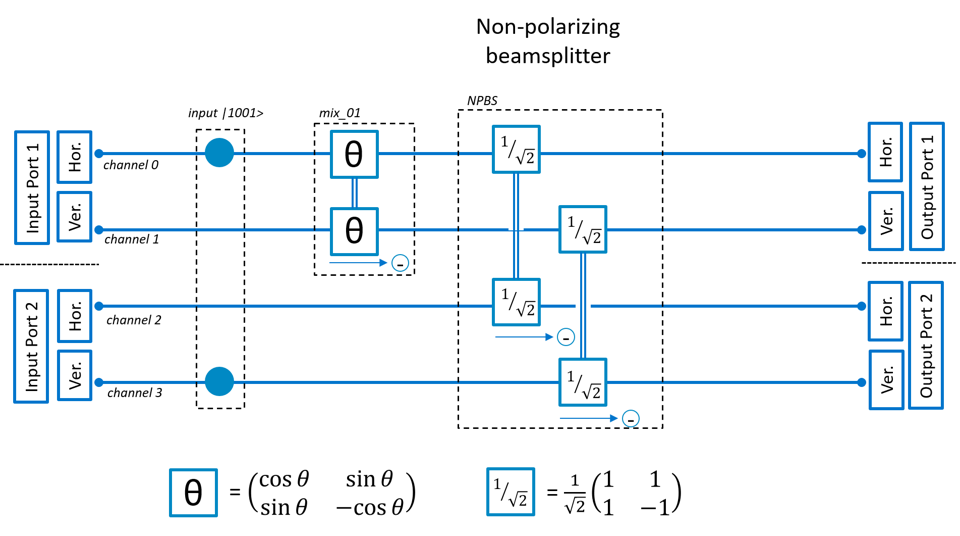

In [26]:
Image(filename='./Setup_mixing01.png')

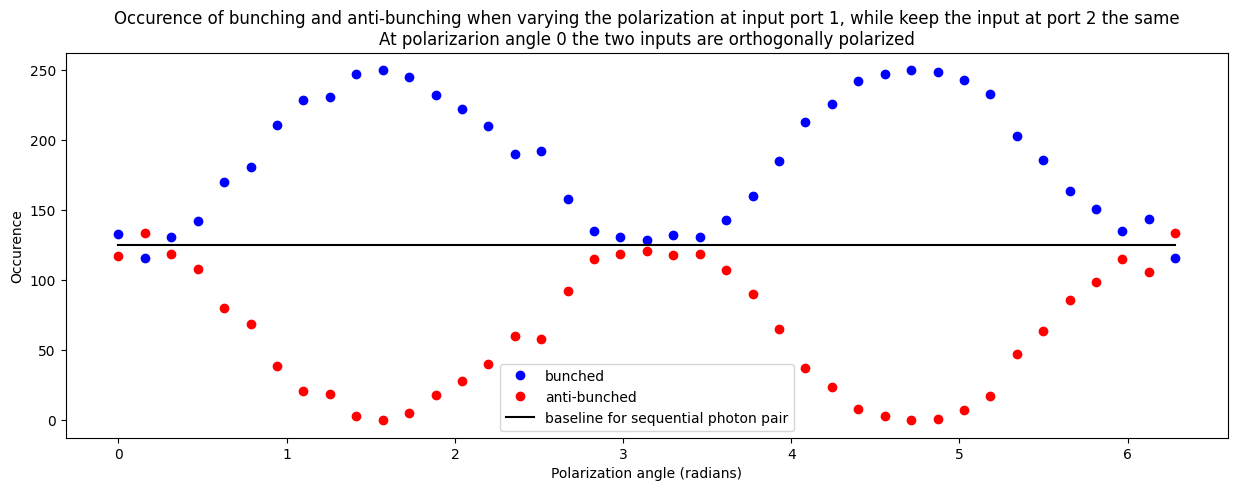

In [27]:
myList = curve.items()
x, y = zip(*myList) 
plt.xlabel("Polarization angle (radians)")
plt.ylabel("Occurence")
plt.plot(x, [pair[0] for pair in y], color = 'blue', linestyle = 'none', marker = 'o')
plt.plot(x, [pair[1] for pair in y], color = 'red', linestyle = 'none', marker = 'o')
plt.plot([0, 2*math.pi], [no_of_measurements/2, no_of_measurements/2], color = 'black', linestyle = '-', marker = 'none')
plt.legend(['bunched', 'anti-bunched', 'baseline for sequential photon pair'])
text1 = 'Occurence of bunching and anti-bunching when varying the polarization at input port 1, while keep the input at port 2 the same'
text2 = 'At polarizarion angle 0 the two inputs are orthogonally polarized'
plt.title(text1 + '\n' + text2)
plt.show()

### Changing the reflection and transmission of the beamsplitter to vary 'indistinguishability'

What we can also do is start with parallel polarized photons for the two ports, but vary the reflectivity and transmissivity of the non-polarizing beamsplitter. If the beamsplitter has transmission of 100% we can fully distinguish the photons, if they transmission is 50% they are fully indistinguishable. Indeed we see in the result a full swing between 100% buching and 100% anti-bunching.

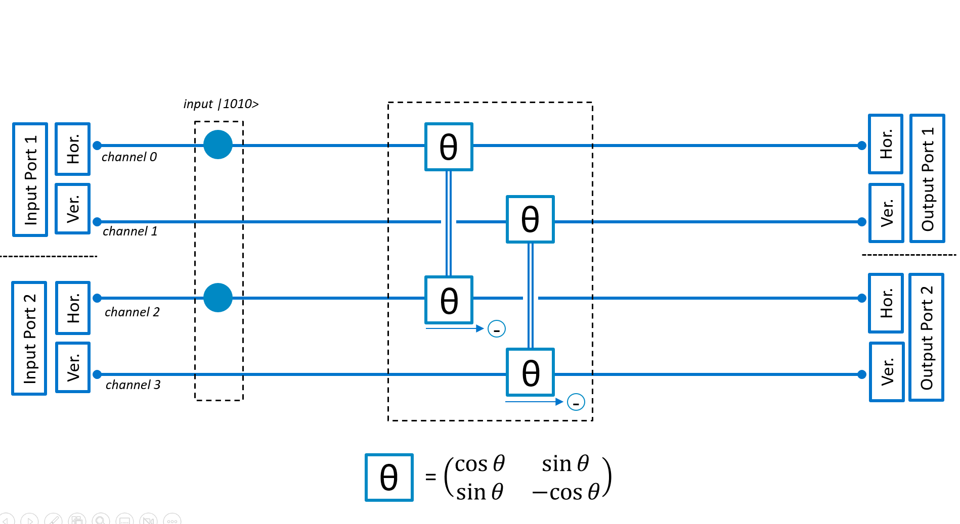

In [28]:
Image(filename='./Setup_variable_beamsplitter.png')

In [29]:
bunched = ['2000','0200', '0020', '0002', '1100', '0011']
antibunched = ['1001','0110', '1010', '0101']
curve = dict([])
no_of_steps_for_rotation = 40
no_of_measurements = 250
for i in range(no_of_steps_for_rotation+1):
    theta = 1*i*math.pi/(no_of_steps_for_rotation)
    mix = tensor(mixing_matrix(math.cos(theta),math.sin(theta)), I, I) # Matrix for mixing first two channels
    GBS = tensor(I, I, I, I) # This is the identity matrix operating on channels [0, 1, 2, 3]
    GBS = mix.permute([0,2,1,3]) * GBS
    GBS = mix.permute([2,0,3,1]) * GBS
    res = photon_pairs_simultaneously([0, 2], GBS, no_of_measurements)
    baseline_bunching = no_of_measurements*2*(math.cos(theta)*math.sin(theta))**2
    baseline_antibunching = no_of_measurements * (math.cos(theta) ** 4 + math.sin(theta) ** 4)
    curve[theta] = [sum([res[code] for code in bunched if code in res]), sum([res[code] for code in antibunched if code in res]), baseline_bunching, baseline_antibunching]


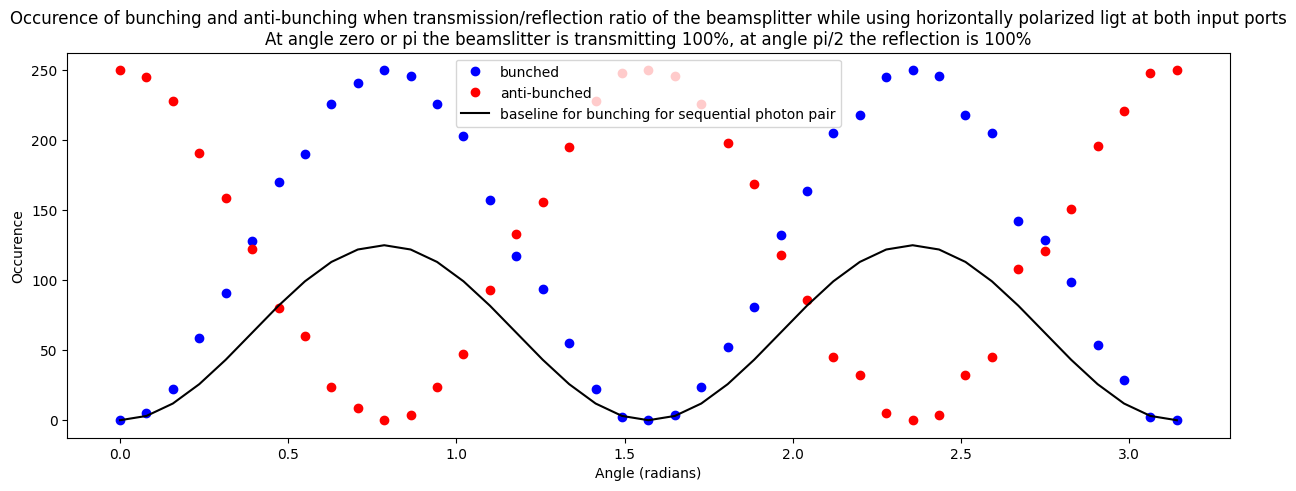

In [30]:
myList = curve.items()
x, y = zip(*myList) 
plt.xlabel("Angle (radians)")
plt.ylabel("Occurence")
plt.plot(x, [pair[0] for pair in y], color = 'blue', linestyle = 'none', marker = 'o')
plt.plot(x, [pair[1] for pair in y], color = 'red', linestyle = 'none', marker = 'o')
plt.plot(x, [pair[2] for pair in y],  color = 'black', linestyle = '-', marker = 'none')
plt.legend(['bunched', 'anti-bunched', 'baseline for bunching for sequential photon pair', 'baseline for bunching for sequential photon pair'])
text1 = 'Occurence of bunching and anti-bunching when transmission/reflection ratio of the beamsplitter while using horizontally polarized ligt at both input ports'
text2 = 'At angle zero or pi the beamslitter is transmitting 100%, at angle pi/2 the reflection is 100%'
plt.title(text1 + '\n' + text2)
plt.show()

### Changing the polarization AFTER the beamsplitter to vary indistinguishability

We can also change the polarization after the beamsplitter as in below illustration. In principle this also leads to 'indistinguishability', but then only after the photons have passed through the beamsplitter. What we will see is that the ration of 'bunching' and 'anti-bunching' is exactly as we would expect without quantum physics (so we do not observe the HOM effect in the beamsplitter, even though we make the photons indistinguishable before detection). What we do see is that we create 'entanglement' between the two photons when they end up in different ports, so still some very interesting quantum behavior to be observed!

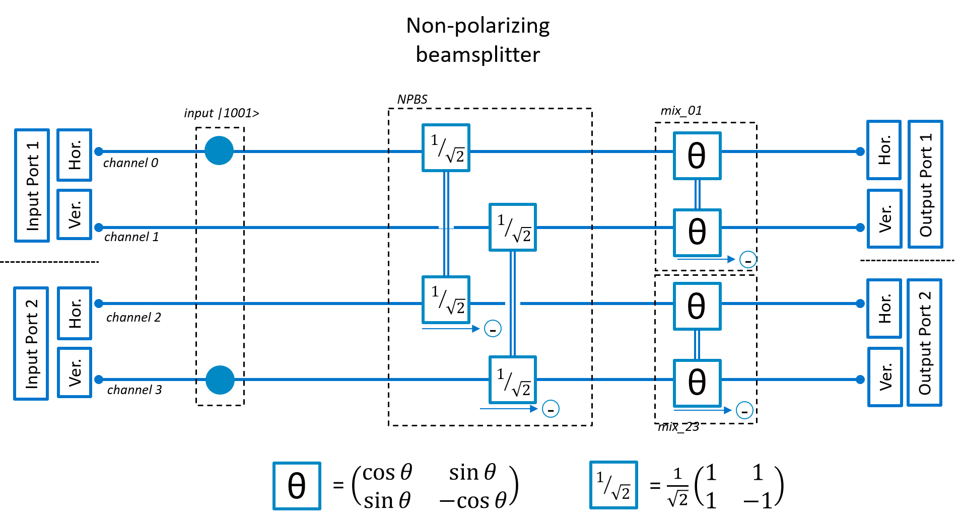

In [31]:
Image(filename='./Setup_mixing_after_beamsplitter.png')

In [32]:
bunched = ['2000','0200', '0020', '0002', '1100', '0011']
antibunched = ['1001','0110', '1010', '0101']
curve = dict([])
no_of_steps_for_rotation = 40
no_of_measurements = 500
for i in range(no_of_steps_for_rotation+1):
    theta = 2*i*math.pi/(no_of_steps_for_rotation)
    mix_01 = tensor(mixing_matrix(math.cos(theta),math.sin(theta)), I, I)
    mix_23 = mix_01.permute([2,3,0,1])
    res = photon_pairs_simultaneously([0, 3], mix_23 * mix_01 * NPBS, no_of_measurements)
    baseline_bunching = 0.5 * no_of_measurements
    curve[theta] = [sum([res[code] for code in bunched if code in res]), sum([res[code] for code in antibunched if code in res]), baseline_bunching]

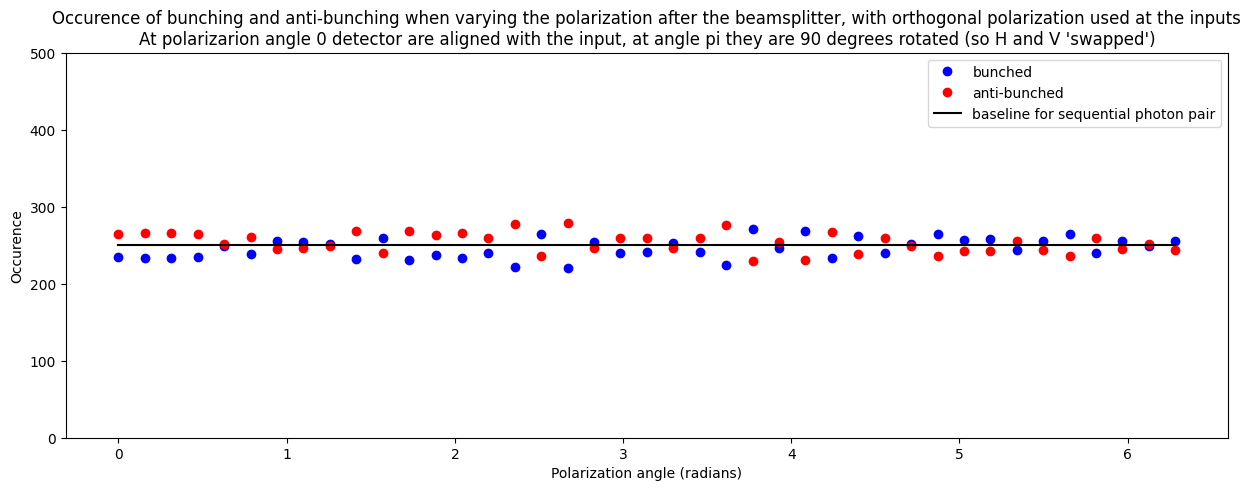

In [33]:
myList = curve.items()
x, y = zip(*myList) 
plt.xlabel("Polarization angle (radians)")
plt.ylabel("Occurence")
plt.plot(x, [pair[0] for pair in y], color = 'blue', linestyle = 'none', marker = 'o')
plt.plot(x, [pair[1] for pair in y], color = 'red', linestyle = 'none', marker = 'o')
plt.plot(x, [pair[2] for pair in y],  color = 'black', linestyle = '-', marker = 'none')
plt.legend(['bunched', 'anti-bunched', 'baseline for sequential photon pair'])
text1 = "Occurence of bunching and anti-bunching when varying the polarization after the beamsplitter, with orthogonal polarization used at the inputs"
text2 = "At polarizarion angle 0 detector are aligned with the input, at angle pi they are 90 degrees rotated (so H and V 'swapped')"
plt.title(text1 + '\n' + text2)
plt.ylim(0, no_of_measurements )
plt.show()

In [34]:
bunched_full = ['2000','0200', '0020', '0002']
bunched_one_side = ['1100', '0011']
antibunched_diff_pol = ['1001','0110']
antibunched_same_pol = ['1010', '0101']
curve = dict([])
no_of_steps_for_rotation = 40
no_of_measurements = 500
for i in range(no_of_steps_for_rotation+1):
    theta = 1*i*math.pi/(no_of_steps_for_rotation)
    mix_01 = tensor(mixing_matrix(math.cos(theta),math.sin(theta)), I, I)
    mix_23 = mix_01.permute([2,3,0,1])
    res = photon_pairs_simultaneously([0, 3], mix_23 * mix_01 * NPBS, no_of_measurements)
    baseline_bunching = no_of_measurements * (math.cos(theta) * math.sin(theta)) ** 2
    baseline_antibunching = no_of_measurements * 0.5 * (math.cos(theta) ** 4 + math.sin(theta) ** 4)
    curve[theta] = [sum([res[code] for code in bunched_full if code in res])]
    curve[theta].append(sum([res[code] for code in bunched_one_side if code in res]))
    curve[theta].append(baseline_bunching)
    curve[theta].append(baseline_antibunching)

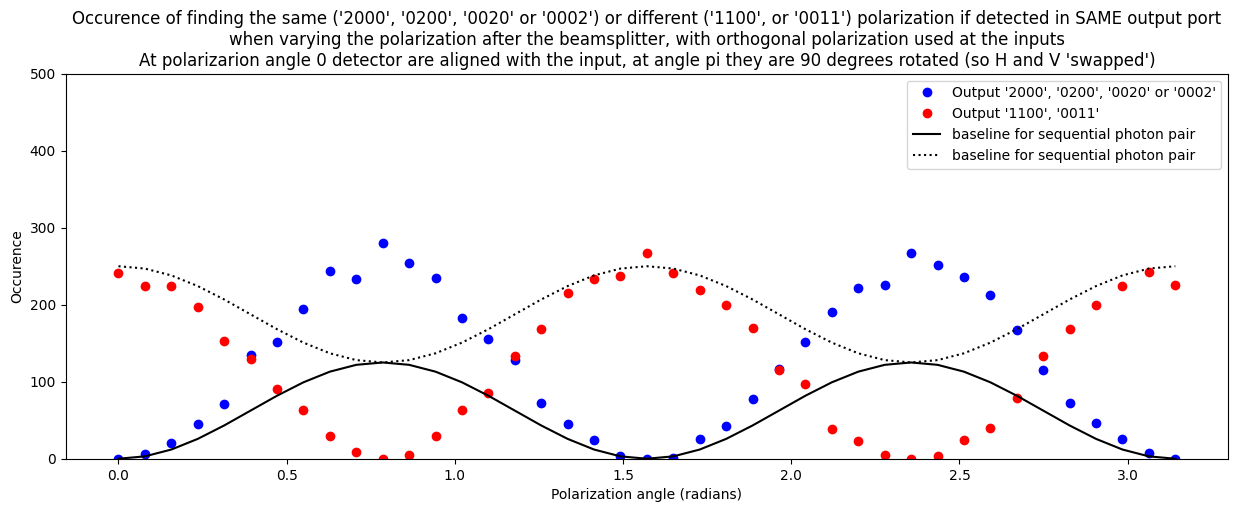

In [35]:
myList = curve.items()
x, y = zip(*myList) 
plt.xlabel("Polarization angle (radians)")
plt.ylabel("Occurence")
plt.plot(x, [pair[0] for pair in y], color = 'blue', linestyle = 'none', marker = 'o')
plt.plot(x, [pair[1] for pair in y], color = 'red', linestyle = 'none', marker = 'o')
plt.plot(x, [pair[2] for pair in y], color = 'black', linestyle = '-', marker = 'none')
plt.plot(x, [pair[3] for pair in y], color = 'black', linestyle = ':', marker = 'none')
plt.legend([
    "Output '2000', '0200', '0020' or '0002'", 
    "Output '1100', '0011'",
    "baseline for sequential photon pair",
    "baseline for sequential photon pair"
    ])
text1 = "Occurence of finding the same ('2000', '0200', '0020' or '0002') or different ('1100', or '0011') polarization if detected in SAME output port"
text2 = "when varying the polarization after the beamsplitter, with orthogonal polarization used at the inputs"
text3 = "At polarizarion angle 0 detector are aligned with the input, at angle pi they are 90 degrees rotated (so H and V 'swapped')"
plt.title(text1 + '\n' + text2 + '\n' + text3)
plt.ylim(0, no_of_measurements )
plt.show()

In [65]:
bunched_full = ['2000','0200', '0020', '0002']
bunched_one_side = ['1100', '0011']
antibunched_diff_pol = ['1001','0110']
antibunched_same_pol = ['1010', '0101']
curve = dict([])
no_of_steps_for_rotation = 40
no_of_measurements = 500
for i in range(no_of_steps_for_rotation+1):
    theta = 1*i*math.pi/(no_of_steps_for_rotation)
    mix_01 = tensor(mixing_matrix(math.cos(theta),math.sin(theta)), I, I)
    mix_23 = mix_01.permute([2,3,0,1])
    res = photon_pairs_simultaneously([0, 3], mix_23 * mix_01 * NPBS, no_of_measurements)
    baseline_same_pol = no_of_measurements * (math.cos(theta) * math.sin(theta)) ** 2
    baseline_diff_pol = no_of_measurements * 0.5 * (math.cos(theta) ** 4 + math.sin(theta) ** 4)
    curve[theta] = [sum([res[code] for code in antibunched_same_pol if code in res])]
    curve[theta].append(sum([res[code] for code in antibunched_diff_pol if code in res]))
    curve[theta].append(baseline_same_pol)
    curve[theta].append(baseline_diff_pol)

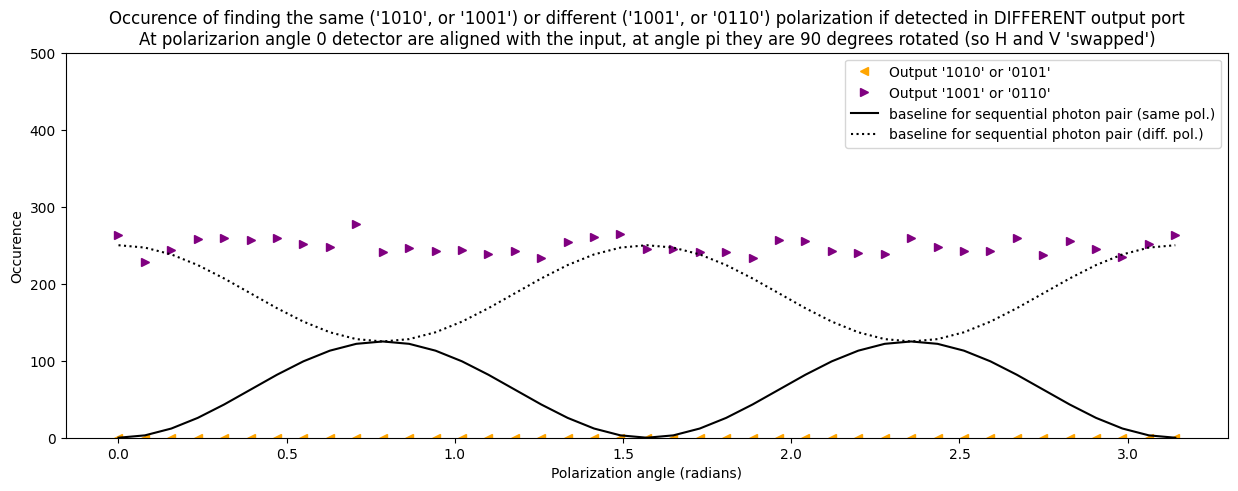

In [66]:
myList = curve.items()
x, y = zip(*myList) 
plt.xlabel("Polarization angle (radians)")
plt.ylabel("Occurence")
plt.plot(x, [pair[0] for pair in y], color = 'orange', linestyle = 'none', marker = '<')
plt.plot(x, [pair[1] for pair in y], color = 'purple', linestyle = 'none', marker = '>')
plt.plot(x, [pair[2] for pair in y], color = 'black', linestyle = '-', marker = 'none')
plt.plot(x, [pair[3] for pair in y], color = 'black', linestyle = ':', marker = 'none')
plt.legend([
    "Output '1010' or '0101'",
    "Output '1001' or '0110'", 
    "baseline for sequential photon pair (same pol.)",
    "baseline for sequential photon pair (diff. pol.)"
    ])
text1 = "Occurence of finding the same ('1010', or '1001') or different ('1001', or '0110') polarization if detected in DIFFERENT output port"
text2 = "At polarizarion angle 0 detector are aligned with the input, at angle pi they are 90 degrees rotated (so H and V 'swapped')"
plt.title(text1 + '\n' + text2)
plt.ylim(0, no_of_measurements )
plt.show()

<a id="Interference"></a>
## Explaining the effect by 'quantum interference' and the 'boson-bonus'

* We have __states__ which consist of __components__. Each __components__ has a specific measurement __outcome__. In the state each __components__ has an __amplitude__ and the __probability__ of detecting the __outcome__ related to a specific __components__ is the square of the absolute value of the __amplitude__. As example consider the state $\alpha \cdot |0101> + \beta \cdot |1010>$. We have probability $|\alpha|^{2}$ of detecting outcome '0101' and $|\beta|^{2}$ of detecting outcome '1010'. Here $|\alpha|^{2} + |\beta|^{2} = 1$, as we need to have a 100% change of detecting two photons. Detecting outcome '1010' means we measure a photon in channels 0 and 2, and no photon in channels 1 and 3.
* manipulate states with matrices
* For states with multiple photons the outcomes at the output have an amplitude with is the __multiplication__ of the amplitudes of the individual photons. As example if we 'build' a two-photon state with component $|0110>$ from single photon states with amplitude $\alpha \cdot |0100>$ and $\beta \cdot |0010>$ then the __amplitude__ of the two-photon component is $\alpha \beta \cdot |0110>$. The __probability__ to detect the outcome '0110' is then $|\alpha\beta|^{2}$
* If the same component appears multiple time in the output it means there are multiple ways to get to that component (for instance two photons could pass through a beamsplitter, or two photons could be reflected to lead to the same end state). In that case we have to add up the amplitudes for these components if we detect the photons simultaneously. This can lead to __quantum interference__ where a probability is reduced due to two amplitudes cancelling eachother for the different ways to get to an component. 
* If a component has more photons in the same channel (so component $|0200>$ or $|0030>$) the component will get an extra multiplier in the amplitude of the square of the photon number. So for $|0200>$ the __boson bonus__ would be $\sqrt{2}$.

### Changing the polarization of the input ports to vary 'indistinguishability'

The photon which starts in channel 3 has two options. Either it will end up in channel 3 (i.e., pass through the NPBS), or it will end up in channel 1 (i.e., is reflected in the beamsplitter). In the first case the amplitude is $-\frac{1}{2} \sqrt{2}$ and in the second case $+\frac{1}{2} \sqrt{2}$ so the state for that photon is $\frac{1}{2} \sqrt{2} \cdot (|0100> - |0001>$. If we would just use that photon the probility to detect it in channel 3 would be 50%, and the probability to detect in channel 1 could be 50%.

The photon starting in channel 0 has more options. It can end up in any of the channels at the output. First when we vary the polarization by 'mixing' channels 0 and 1 the photon can stay horizontally polarized and remain in channel 0. This gives an amplitude $\cos(\Theta)$. If the photon is deflected to channel 1 (change polarization to vertical) the amplitude is $\sin(\Theta)$. Then in each of these cases the photon either passes through the beamsplitter, or is reflected. This all with amplitude $\frac{1}{2} \sqrt{2}$. So the photon ends up in the state $\frac{1}{2} \sqrt{2} \cdot (\cos(\Theta)|1000> + \sin(\Theta)|0100> + \cos(\Theta)|0010> + \sin(\Theta)|0001>$. If we would just use this photon the probility to detect it in for instance channel 0 (outcome '1000') would be $\frac{1}{4}\cos(\Theta)$

Now we look at the two photons travelling through the system simultaneously. We then look at the amplitude of the single photons and multiply then to get to the amplitude of the corresponding component in the final state. This final state in principle has 8 components (two options for the photon starting in channel 3 multiplied by four options for the photon starting in channel 0).

First look at the outcomes where both photons end up with different polarization (so one horizontally and the other vertically polarized). We find that all these outcomes have the same probability.

$\begin{array}{lcl|lcl}
\text{Amplitude of component } |1001> & : &  -\frac{1}{2} \cos(\Theta) & P('1001') &=& \frac{1}{4} \cos(\Theta)^{2}\\[9pt] 
\text{Amplitude of component } |1100> & : &  +\frac{1}{2} \cos(\Theta) & P('1100') &=& \frac{1}{4} \cos(\Theta)^{2}\\[9pt] 
\text{Amplitude of component } |0011> & : &  -\frac{1}{2} \cos(\Theta) & P('0011') &=& \frac{1}{4} \cos(\Theta)^{2}\\[9pt] 
\text{Amplitude of component } |0110> & : &  +\frac{1}{2} \cos(\Theta) & P('0110') &=& \frac{1}{4} \cos(\Theta)^{2}
\end{array}$

Now lets look at the outcomes where both photons have the same polarization. As the photon staring in channel 3 will always remain vertically polarized we only have to look at both photons vertically polarized behind different ports (outcome '0101'), both behind port 1 (outcome '0200') or both behind port 3 (outcome '0002'). Now we see the two quantum effects in action. 

For the first case (outcome '0101') there are two ways of creating it. We could have the photon from channel 0 end up in channel 1, and the photon from channel 3 remain in channel 3. We could also have the photon from channel 0 end up in channel 3, and the photon from channel 3 switch to channel 1. See the picture below for a graphical illustration. If we calculate the amplitudes for these different 'paths' we see that they exactly cancel when we add them up (one has a minus sign). Mathematically this is because only when the photon travels from channel 3 to channel 3 it picks up the minus sign. As the amplitudes are equally large, but with opposite sign they exactly cancel out. This is __quantum interference__ in action.

For the components with two photons in the same channel we have to apply the __boson bonus__ and add a factor $\sqrt{2}$. We nicely see that when we add up the probabilities for all possible outcome it is still one.

$\begin{array}{lcl|lcl}
\text{Amplitude of component } |0101> & : &  \frac{1}{2} \sin(\Theta) - \frac{1}{2} \sin(\Theta) & P('0101') &=& 0\\[9pt] 
\text{Amplitude of component } |0200> & : &  -\frac{1}{2} \sin(\Theta) \sqrt(2) & P('0200') &=& \frac{1}{2} \sin(\Theta)^{2}\\[9pt] 
\text{Amplitude of component } |0002> & : &  \frac{1}{2} \cos(\Theta) \sqrt(2) & P('0002') &=& \frac{1}{2} \sin(\Theta)^{2}
\end{array}$

Now we can look at the measurements for 'bunching' and 'anti-bunching'. For 'bunching' we add up the probabilities for outcomes '0200', '0002', '1100' and '0011'. This is $\frac{1}{2} \cos(\Theta)^{2} + \sin(\Theta)^{2}$. For 'anti-bunching' we then add up the probabilities for '1001' and '0110', which is  $\frac{1}{2} \cos(\Theta)^{2}$. All other outcomes have probability zero. Below we plot this calculated probabilty against the result of the computer experiment to see the perfect match. 

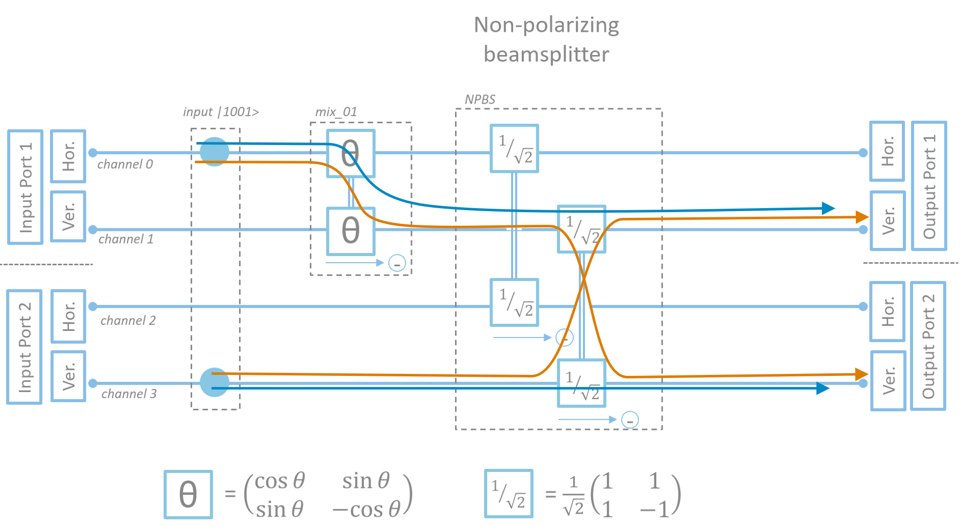

In [38]:
Image(filename='./Setup_mixing01_quantum_interference.png')

In [39]:
bunched = ['2000','0200', '0020', '0002', '1100', '0011']
antibunched = ['1001','0110', '1010', '0101']
curve = dict([])
no_of_steps_for_rotation = 40
no_of_measurements = 250
for i in range(no_of_steps_for_rotation+1):
    theta = 2*i*math.pi/(no_of_steps_for_rotation)
    mix_01 = tensor(mixing_matrix(math.cos(theta),math.sin(theta)), I, I)
    res = photon_pairs_simultaneously([0, 3], NPBS * mix_01, no_of_measurements)
    bunch_model = no_of_measurements * (0.5 * math.cos(theta)**2 + math.sin(theta)**2)
    antibunch_model = no_of_measurements * 0.5 * math.cos(theta)**2
    curve[theta] = [sum([res[code] for code in bunched if code in res]), sum([res[code] for code in antibunched if code in res])]
    curve[theta].append(bunch_model)
    curve[theta].append(antibunch_model)

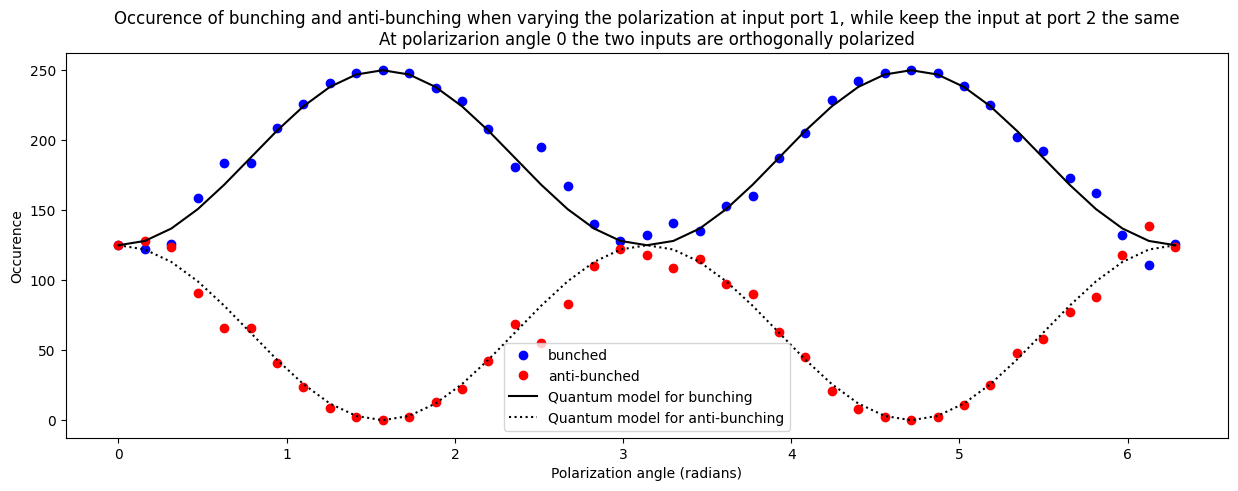

In [40]:
myList = curve.items()
x, y = zip(*myList) 
plt.xlabel("Polarization angle (radians)")
plt.ylabel("Occurence")
plt.plot(x, [pair[0] for pair in y], color = 'blue', linestyle = 'none', marker = 'o')
plt.plot(x, [pair[1] for pair in y], color = 'red', linestyle = 'none', marker = 'o')
plt.plot(x, [pair[2] for pair in y], color = 'black', linestyle = '-', marker = 'none')
plt.plot(x, [pair[3] for pair in y], color = 'black', linestyle = ':', marker = 'none')
plt.legend(['bunched', 'anti-bunched', 'Quantum model for bunching', 'Quantum model for anti-bunching'])
text1 = 'Occurence of bunching and anti-bunching when varying the polarization at input port 1, while keep the input at port 2 the same'
text2 = 'At polarizarion angle 0 the two inputs are orthogonally polarized'
plt.title(text1 + '\n' + text2)
plt.show()

### Changing the reflection and transmission of the beamsplitter to vary 'indistinguishability'

In the case where we vary the reflectance and transmittance of the beamsplitter we can do similar analysis. In this case we have a photon starting in channel 0, which can either remain in 0 (with amplitude $\cos(\Theta)$), or be deflected to channel 3 (with amplitude $\sin(\Theta)$). The photon starting in channel 3 either remains in channel 3, with amplitude $-\cos(\Theta)$ (note the minus sign!), or is reflected to channel 0 with amplitude $\sin(\Theta)$. The components in the final state then look like:

$\begin{array}{lcl|lcl}
\text{Amplitude of component } |2000> & : &  \cos(\Theta)\sin(\Theta) \cdot \sqrt(2) & P('2000') &=& 2\cos(\Theta)^{2}\sin(\Theta)^{2}\\[9pt] 
\text{Amplitude of component } |0020> & : &  -\cos(\Theta)\sin(\Theta) \cdot \sqrt(2) & P('0020') &=& 2\cos(\Theta)^{2}\sin(\Theta)^{2}\\[9pt] 
\text{Amplitude of component } |1010> & : &  \sin(\Theta)^{2} -  \cos(\Theta)^{2}  & P('1010') &=& (\sin(\Theta)^{2} -  \cos(\Theta)^{2})^{2}\\[9pt] 
\end{array}$

In [41]:
bunched = ['2000','0200', '0020', '0002', '1100', '0011']
antibunched = ['1001','0110', '1010', '0101']
curve = dict([])
no_of_steps_for_rotation = 40
no_of_measurements = 250
for i in range(no_of_steps_for_rotation+1):
    theta = 1*i*math.pi/(no_of_steps_for_rotation)
    mix = tensor(mixing_matrix(math.cos(theta),math.sin(theta)), I, I) # Matrix for mixing first two channels
    GBS = tensor(I, I, I, I) # This is the identity matrix operating on channels [0, 1, 2, 3]
    GBS = mix.permute([0,2,1,3]) * GBS
    GBS = mix.permute([2,0,3,1]) * GBS
    res = photon_pairs_simultaneously([0, 2], GBS, no_of_measurements)
    bunch_model = no_of_measurements*4*(math.cos(theta)*math.sin(theta))**2
    antibunch_model = no_of_measurements * (math.sin(theta) ** 2 - math.cos(theta) ** 2) ** 2
    curve[theta] = [sum([res[code] for code in bunched if code in res]), sum([res[code] for code in antibunched if code in res]), bunch_model, antibunch_model]


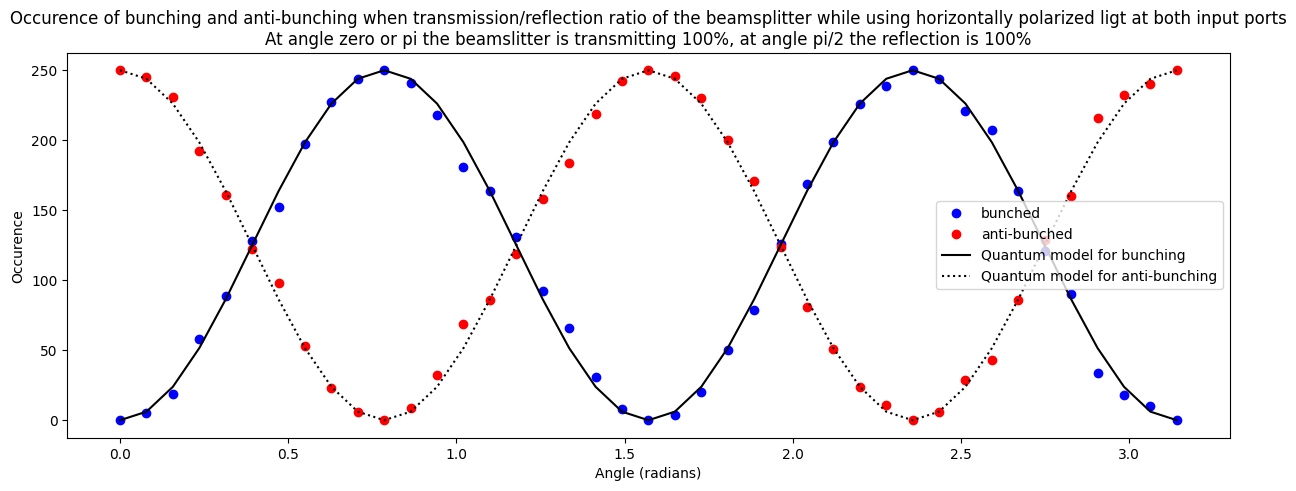

In [42]:
myList = curve.items()
x, y = zip(*myList) 
plt.xlabel("Angle (radians)")
plt.ylabel("Occurence")
plt.plot(x, [pair[0] for pair in y], color = 'blue', linestyle = 'none', marker = 'o')
plt.plot(x, [pair[1] for pair in y], color = 'red', linestyle = 'none', marker = 'o')
plt.plot(x, [pair[2] for pair in y],  color = 'black', linestyle = '-', marker = 'none')
plt.plot(x, [pair[3] for pair in y],  color = 'black', linestyle = ':', marker = 'none')
plt.legend(['bunched', 'anti-bunched', 'Quantum model for bunching', 'Quantum model for anti-bunching'])
text1 = 'Occurence of bunching and anti-bunching when transmission/reflection ratio of the beamsplitter while using horizontally polarized ligt at both input ports'
text2 = 'At angle zero or pi the beamslitter is transmitting 100%, at angle pi/2 the reflection is 100%'
plt.title(text1 + '\n' + text2)
plt.show()

### Changing the polarization AFTER the beamsplitter to vary indistinguishability

For the case where we use polarization rotation after the beamsplitters single photons (starting in channel 0 or channel 3) can end up at any of the output ports with likelihood depending on the polarization angle. For the sign of the amplitudes we see that the photon starting in channel 3 can pick up a minus sign when passing through the NPBS, and when passing through the polarization rotators behind the ports. 

For a photon starting in channel 0 ($|1000>$) the end-states is:

$\frac{1}{\sqrt{2}} \cdot (\cos(\Theta)|1000> + \sin(\Theta)|0100> + \cos(\Theta)|0010> + \sin(\Theta)|0001>$

For a photon starting in channel 3 ($|0001>$) the end-states is:

$\frac{1}{\sqrt{2}} \cdot (\sin(\Theta)|1000> - \cos(\Theta)|0100> - \sin(\Theta)|0010> + \cos(\Theta)|0001>$


From this we can assess the end state when we start with the two photon state $|1001>$. First look at the components with two photons in the same channel. The probability for any of these outcomes is the same ($\frac{1}{2}\cos(\Theta)^{2}\sin(\Theta)^{2}$). The total likelihood of finding the two photons in one channel is $2\cos(\Theta)^{2}\sin(\Theta)^{2}$ or $\frac{1}{2}\sin(2\Theta)^{2}$

$\begin{array}{lcl|lcl}
\text{Amplitude of component } |2000> & : &  +\frac{1}{2}\cos(\Theta)\sin(\Theta) \cdot \sqrt(2) & P('2000') &=& \frac{1}{2}\cos(\Theta)^{2}\sin(\Theta)^{2}\\[9pt] 
\text{Amplitude of component } |0200> & : &  -\frac{1}{2}\cos(\Theta)\sin(\Theta) \cdot \sqrt(2) & P('0200') &=& \frac{1}{2}\cos(\Theta)^{2}\sin(\Theta)^{2}\\[9pt] 
\text{Amplitude of component } |0020> & : &  +\frac{1}{2}\cos(\Theta)\sin(\Theta) \cdot \sqrt(2) & P('0020') &=& \frac{1}{2}\cos(\Theta)^{2}\sin(\Theta)^{2}\\[9pt] 
\text{Amplitude of component } |0002> & : &  -\frac{1}{2}\cos(\Theta)\sin(\Theta) \cdot \sqrt(2) & P('0002') &=& \frac{1}{2}\cos(\Theta)^{2}\sin(\Theta)^{2} 
\end{array}$

For finding the two photons behind the same port in different channels (i.e., with different polarization) the probabilities are calculated below. Each of these outcomes has likelihood $\frac{1}{4}(\sin(\Theta)^{2} - \cos(\Theta)^{2})^{2}$, and for them together it is $\frac{1}{2}\cos(2\Theta)^{2}$. What we see is that the total probability for a 'bunched' outcome is $\frac{1}{2}$ as indeed we observe in the simulation. This is also the prediction without quantum effectc (or the prediction for photon pairs that arrive sequentially). 

$\begin{array}{lcl|lcl}
\text{Amplitude of component } |1100> & : &  +\frac{1}{2}(\sin(\Theta)^{2} - \cos(\Theta)^{2}) & P('1100') &=& \frac{1}{4}(\sin(\Theta)^{2} - \cos(\Theta)^{2})^{2}\\[9pt] 
\text{Amplitude of component } |0011> & : &  +\frac{1}{2}(\sin(\Theta)^{2} - \cos(\Theta)^{2}) & P('1100') &=& \frac{1}{4}(\sin(\Theta)^{2} - \cos(\Theta)^{2})^{2}\\[9pt] 
\end{array}$

Then we can look at anti-bunching where the two photons end up behind different ports. Logically the total occurence should be 50% (as the other 50% we should find a 'bunched' outcome). What is surprising is that the likelihood for finding the same polarization is zero. We only find antibunching with different polarizations! So while behind every port we find (for anti-bunching) a random polarization, of we compare the detection of horizontal or vertical polarization between the two ports we find a perfect anti-correlation. This is an example of entanglement, created from two non-entangled photons by means of a simple beamsplitter (so full linear optics) !! 

$\begin{array}{lcl|lcl}
\text{Amplitude of component } |1010> & : &  +\frac{1}{2}(\cos(\Theta)\sin(\Theta) - \sin(\Theta) \cos(\Theta)) & P('1010') &=& 0 \\[9pt] 
\text{Amplitude of component } |0101> & : &  +\frac{1}{2}(\cos(\Theta)\sin(\Theta) - \sin(\Theta) \cos(\Theta)) & P('0101') &=& 0
\end{array}$

$\begin{array}{lcl|lcl}
\text{Amplitude of component } |1001> & : &  +\frac{1}{2}(\cos(\Theta)^{2} + \sin(\Theta)^{2}) & P('1001') &=& \frac{1}{4}\\[9pt] 
\text{Amplitude of component } |0110> & : &  -\frac{1}{2}(\cos(\Theta)^{2} + \sin(\Theta)^{2}) & P('0110') &=& \frac{1}{4}
\end{array}$

In [43]:
bunched_full = ['2000','0200', '0020', '0002']
bunched_one_side = ['1100', '0011']
antibunched_diff_pol = ['1001','0110']
antibunched_same_pol = ['1010', '0101']
curve = dict([])
no_of_steps_for_rotation = 40
no_of_measurements = 500
for i in range(no_of_steps_for_rotation+1):
    theta = 1*i*math.pi/(no_of_steps_for_rotation)
    mix_01 = tensor(mixing_matrix(math.cos(theta),math.sin(theta)), I, I)
    mix_23 = mix_01.permute([2,3,0,1])
    res = photon_pairs_simultaneously([0, 3], mix_23 * mix_01 * NPBS, no_of_measurements)
    quantum_model_same_pol = no_of_measurements * (1/2) * (math.sin(2*theta) ** 2)
    quantum_model_diff_pol = no_of_measurements * (1/2) * (math.cos(2*theta) ** 2)
    curve[theta] = [sum([res[code] for code in bunched_full if code in res])]
    curve[theta].append(sum([res[code] for code in bunched_one_side if code in res]))
    curve[theta].append(quantum_model_same_pol)
    curve[theta].append(quantum_model_diff_pol)

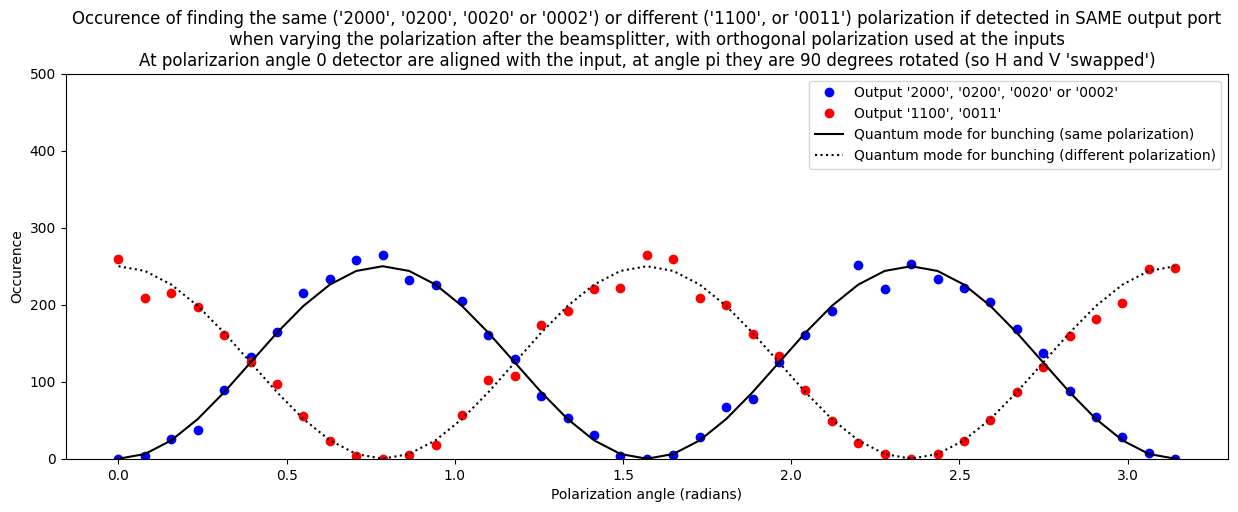

In [44]:
myList = curve.items()
x, y = zip(*myList) 
plt.xlabel("Polarization angle (radians)")
plt.ylabel("Occurence")
plt.plot(x, [pair[0] for pair in y], color = 'blue', linestyle = 'none', marker = 'o')
plt.plot(x, [pair[1] for pair in y], color = 'red', linestyle = 'none', marker = 'o')
plt.plot(x, [pair[2] for pair in y], color = 'black', linestyle = '-', marker = 'none')
plt.plot(x, [pair[3] for pair in y], color = 'black', linestyle = ':', marker = 'none')
plt.legend([
    "Output '2000', '0200', '0020' or '0002'", 
    "Output '1100', '0011'",
    "Quantum mode for bunching (same polarization)",
    "Quantum mode for bunching (different polarization)"
    ])
text1 = "Occurence of finding the same ('2000', '0200', '0020' or '0002') or different ('1100', or '0011') polarization if detected in SAME output port"
text2 = "when varying the polarization after the beamsplitter, with orthogonal polarization used at the inputs"
text3 = "At polarizarion angle 0 detector are aligned with the input, at angle pi they are 90 degrees rotated (so H and V 'swapped')"
plt.title(text1 + '\n' + text2 + '\n' + text3)
plt.ylim(0, no_of_measurements )
plt.show()

In [45]:
bunched_full = ['2000','0200', '0020', '0002']
bunched_one_side = ['1100', '0011']
antibunched_diff_pol = ['1001','0110']
antibunched_same_pol = ['1010', '0101']
curve = dict([])
no_of_steps_for_rotation = 40
no_of_measurements = 500
for i in range(no_of_steps_for_rotation+1):
    theta = 1*i*math.pi/(no_of_steps_for_rotation)
    mix_01 = tensor(mixing_matrix(math.cos(theta),math.sin(theta)), I, I)
    mix_23 = mix_01.permute([2,3,0,1])
    res = photon_pairs_simultaneously([0, 3], mix_23 * mix_01 * NPBS, no_of_measurements)
    quantum_model_same_pol = no_of_measurements * (1/2) * (0)
    quantum_model_diff_pol = no_of_measurements * (1/2) * (1)
    curve[theta] = [sum([res[code] for code in antibunched_same_pol if code in res])]
    curve[theta].append(sum([res[code] for code in antibunched_diff_pol if code in res]))
    curve[theta].append(quantum_model_same_pol)
    curve[theta].append(quantum_model_diff_pol)

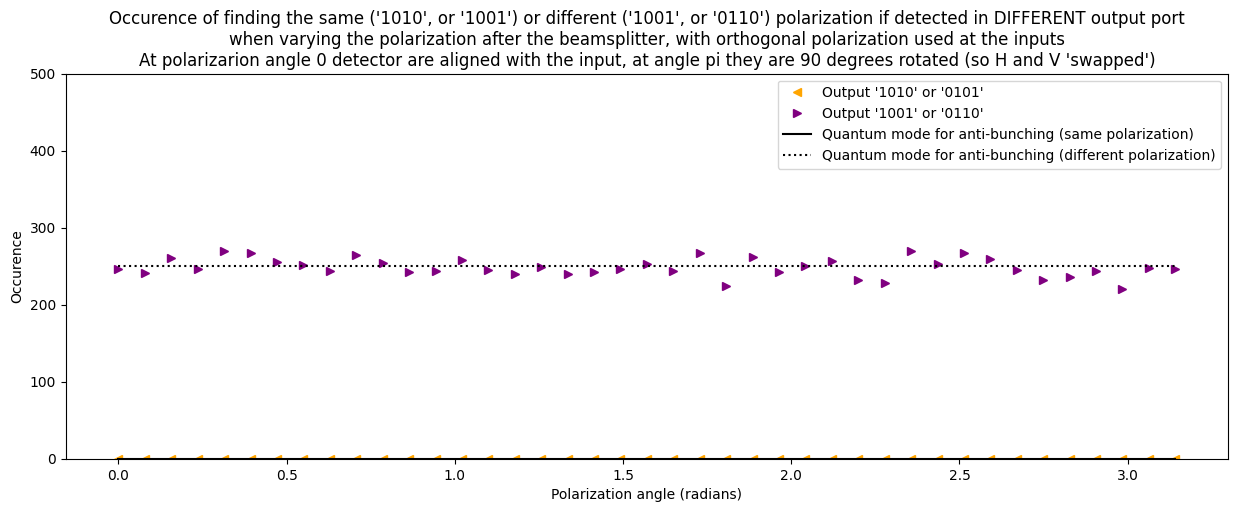

In [50]:
myList = curve.items()
x, y = zip(*myList) 
plt.xlabel("Polarization angle (radians)")
plt.ylabel("Occurence")
plt.plot(x, [pair[0] for pair in y], color = 'orange', linestyle = 'none', marker = '<')
plt.plot(x, [pair[1] for pair in y], color = 'purple', linestyle = 'none', marker = '>')
plt.plot(x, [pair[2] for pair in y], color = 'black', linestyle = '-', marker = 'none')
plt.plot(x, [pair[3] for pair in y], color = 'black', linestyle = ':', marker = 'none')
plt.legend([
    "Output '1010' or '0101'",
    "Output '1001' or '0110'", 
    "Quantum mode for anti-bunching (same polarization)",
    "Quantum mode for anti-bunching (different polarization)"
    ])
text1 = "Occurence of finding the same ('1010', or '1001') or different ('1001', or '0110') polarization if detected in DIFFERENT output port"
text2 = "when varying the polarization after the beamsplitter, with orthogonal polarization used at the inputs"
text3 = "At polarizarion angle 0 detector are aligned with the input, at angle pi they are 90 degrees rotated (so H and V 'swapped')"
plt.title(text1 + '\n' + text2 + '\n' + text3)
plt.ylim(0, no_of_measurements )
plt.show()